# Busting the Box Office

The motivation of my tutorial is to learn more about the films that gross the most domestically in the United States at the movie theaters. In the 21st century, we've seen drastic changes in our society that have heavily impacted the movie industry. 

Many people cite the decline in popularity of original films and the rise and dominance of adapted films, films that have been adapted from some sort of prior media like a graphic novel or book; remakes, films that are based on older films, attempting to recreate them; and franchise films, films the are part of a series of films, forming an interconnecting story across titles. Many critics have opposed these types of “blockbuster” films, which often have immense budgets and outrageous marketing campaigns, as being derivative of the [art of cinema](https://www.nytimes.com/2019/11/04/opinion/martin-scorsese-marvel.html), favoring producing a product for mass appeal over making a unique and thought provoking piece of art.

Another major factor was the rise of [streaming services](https://sites.marjon.ac.uk/doughnut/2022/05/06/are-streaming-services-causing-the-death-of-cinema/) as an alternative form of entertainment. With the popularity of Netflix and the services of other companies attempting to do the same, many casual moviegoers have less incentive to go to the multiplex, and favor the comfort of staying at home to watch one of the countless television series and films that these services offer. Streaming is much more affordable and less of a commitment for the user, and those are many of the reasons why many customers have opted against going to the theaters to watch a newly-released film.

The decline in interest of going to the movies was further exacerbated by the COVID-19 pandemic which shut down the world in March 2020. Which forced movie theaters to shut down due to the high risk of infection and government mandates. This also initially delayed the release of many major films, as film executives surely did not want to lose much of their revenue by releasing at a time when viewers wouldn’t be going to the cinema. While most theaters have been opening up since the Summer of 2020, the rise of many waves of variants since then have kept many people out of the theaters, especially older viewers and those who are at most risk of getting infected. Even still, vaccines that prevent harsh symptoms have been widely available since the middle of 2021, so whether moviegoers are still avoiding due to the virus or if they have found other ways to entertain themselves (aka streaming), remains to be seen. [More info here.](https://variety.com/2021/film/news/movie-theaters-box-office-2021-pandemic-omicron-1235142992/)

Thus, in this tutorial, I will try to explore how these causes may have impacted the movie industry. I will be checking to see if the highest grossing films are generally approved by critics. I would then also compare the pre-COVID statistics to those found after March 2020 to see if there exists any shifts in the preference of American moviegoers.



## Data Scraping

I'm going to be taking all of the box office data from Box Office Mojo, which is a public website that tracks box-office revenues of films generally and according to many different criteria. I will first attempt to scrape the Top 50 highest grossing films from 2000 to 2021. At the same time, I am scraping Wikipedia for the movie critic review score from [Rotten Tomatoes](https://www.rottentomatoes.com/), and combining all theormation into the same database. Rotten Tomatoes presents an aggregate review score of certified critics for each film based on whether they thought it was “Fresh” or “Rotten,” effectively whether they liked it or not. The result is a percentage of critics who thought the film was “Fresh.” We are using these reviews because they are one of the most popular review websites, with a “Certified Fresh” rating often being boasted about by films in their advertising campaigns.

There are also other popular review sites that we can test on including [Metacritic](https://www.metacritic.com/), but in the following code we will be using the Rotten Tomatoes data.

While there exists an [API](https://www.programmableweb.com/api/rotten-tomatoes-rest-api) to find the Rotten Tomatoes score of any films, this is not publicly available, which is why I’ve opted to find an alternative solution by writing a script to scrape the score from its wikipedia page, which is always present for each film’s page.

I decided to individually scrape each wikipedia page for each movie using the publicly available [Wikipedia API](https://wikipedia.readthedocs.io/en/latest/).

In [321]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import wikipedia
import matplotlib as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [119]:
# filling up list of urls to yearly domestic Box Office for that year
urls = list()
for i in range(2000, 2022):
    urls.append("https://www.boxofficemojo.com/year/{}/?grossesOption=totalGrosses&sort=rank&sortDir=asc".format(i))

I want to eventually be able to normalize my domestic gross data by the number of tickets sold. Since the ticket price has skyrocketed over the years, while a newer movie with a higher gross might look like it is doing better at the box office than an older film, it could potentially have less people purchasing a ticket for it.

Using the same wikipedia API, I look at the wikipedia page for ["Box Office"](https://en.wikipedia.org/wiki/Box_office#Average_ticket_price) I scrape the average ticket price table up to the year 2020, and I add 2021 for consistency. 

In [161]:
# Finding average American ticket price from wikipedia page (2000-2020)
search_title = wikipedia.search("Box office")
wiki = wikipedia.page(search_title[0], auto_suggest=False)
soup = bs(wiki.html(), 'html.parser')
##print(soup.table)
avg_tkt_price = pd.read_html(str(soup.table))[0]
avg_tkt_price_usa = avg_tkt_price[["Year[42]", "USA[44]"]]
avg_tkt_price_usa = avg_tkt_price_usa.rename(columns={"Year[42]": "Year_ugly", "USA[44]": "Price"})
print(type(avg_tkt_price_usa.Price[45]))
avg_tkt_price_usa = avg_tkt_price_usa.dropna(subset=['Price'])

avg_tkt_price_usa['Price_val'] = avg_tkt_price_usa.apply(lambda row: float(sub(r'[^\d.]', '', row.Price)), axis=1)
avg_tkt_price_usa['Year'] = avg_tkt_price_usa['Year_ugly'].str.slice(0,4)
avg_tkt_price_usa = avg_tkt_price_usa.drop(columns=['Year_ugly'])
avg_tkt_price_usa = avg_tkt_price_usa.set_index('Year')
# Since we also want to do work with 2021 data, I added the average ticket price for 2021 found here:
# https://www.statista.com/statistics/187091/average-ticket-price-at-north-american-movie-theaters-since-2001/#:~:text=Ticket%20price%20at%20U.S.%20movie%20theaters%202009%2D2021&text=In%202021%2C%20the%20average%20price,from%208.65%20dollars%20in%202016.
avg_tkt_price_usa.loc['2021'] = ["$9.57", 9.57]

print(avg_tkt_price_usa)



<class 'str'>
      Price  Price_val
Year                  
1951  $0.53       0.53
1953  $0.60       0.60
1954  $0.45       0.45
1956  $0.50       0.50
1959  $0.51       0.51
1961  $0.69       0.69
1962  $0.70       0.70
1963  $0.85       0.85
1964  $0.93       0.93
1965  $1.01       1.01
1966  $1.09       1.09
1967  $1.20       1.20
1968  $1.31       1.31
1969  $1.42       1.42
1970  $1.55       1.55
1971  $1.65       1.65
1972  $1.70       1.70
1973  $1.77       1.77
1974  $1.87       1.87
1975  $2.05       2.05
1976  $2.13       2.13
1977  $2.23       2.23
1978  $2.34       2.34
1979  $2.51       2.51
1980  $2.69       2.69
1981  $2.78       2.78
1982  $2.94       2.94
1983  $3.15       3.15
1984  $3.36       3.36
1985  $3.55       3.55
1986  $3.71       3.71
1987  $3.91       3.91
1988  $4.11       4.11
1989  $3.97       3.97
1990  $4.23       4.23
1991  $4.21       4.21
1992  $4.15       4.15
1993  $4.14       4.14
1994  $4.18       4.18
1995  $4.35       4.35
1996  $4.42       4.

In [237]:
import re
import nltk 
from nltk import tokenize

nltk.download('punkt')

# separates strings into tokens to be parsed
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

top_yearly_grosses = dict()
year = 2000
notfound_yearly = dict()
for url in urls:
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    ##print(soup.table)
    df = pd.read_html(str(soup.table))[0]
    all_links = ["https://www.boxofficemojo.com/" + link.get('href') for link in soup.table.find_all('a', rel=lambda x: x != 'noopener')]
    #print(all_links)
    df['URL'] = all_links[7:]
    top_yearly_grosses[year] = df.head(50)
    

    rt_scores = list()
    for row in top_yearly_grosses[year]['Release']:
        #print("finding page for ", row)
        if row == "This Is It":
            row = "Michael Jackson's This Is It"

        if row == "Spy":
            row = "Spy (2015 film)"

        search_title = wikipedia.search(row)
        #search_title = [x for x in search_title if x]
        #print(search_title)
        wt = ""
        #print("finding page for ", row)
        for title in search_title:
            try:
                wiki = wikipedia.page(title, auto_suggest=False)
            except wikipedia.DisambiguationError as e:
                #print(type(e.options))
                #print(e.options)
                films = [x for x in e.options if str(year) in x or "(film)" in x or str(year-1) in x]
                search_title.append(films)
                continue
            except Exception:
                continue
            
            wt = wiki.content
            if "rotten tomatoes" in wt.lower():
                break
        
        #wt = wiki.content
        sentences = tokenizer.tokenize(wt)
        #print(sentences)
        found = False
        checkNext = False
        notfound = list()
        #print(sentences)
        for s in sentences:
            if "rotten tomatoes" in s.lower() or checkNext:
                #print(s)
                x = re.search('(\d{0,3})\%', s)
                if x is None:
                    checkNext = True
                    continue
                #print(row, x.group(1))
                rt_scores.append(x.group(1))
                found = True
                checkNext = False
                break
        
        if not found:
            rt_scores.append(None)
    
    top_yearly_grosses[year]['rt_score'] = rt_scores
    notfound_yearly[year] = notfound
    #print("Scores not found for: ", notfound)                
    year += 1


#print(top_yearly_grosses)
for year, dic in top_yearly_grosses.items():
    print(dic.head(10))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl3059189249/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl2772993537/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl1600292353/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Dinosaur 64
finding page for  Crouching Tiger, Hidden Dragon
Crouching Tiger, Hidden Dragon 97
finding page for  Erin Brockovich
Erin Brockovich 85
finding page for  Charlie's Angels
Charlie's Angels 68
finding page for  Traffic
Traffic 27
finding page for  Nutty Professor II: The Klumps
Nutty Professor II: The Klumps 64
finding page for  Big Momma's House
Big Momma's House 30
finding page for  Remember the Titans
Remember the Titans 73
finding page for  The Patriot
The Patriot 62
finding page for  Chicken Run
Chicken Run 97
finding page for  Miss Congeniality
Miss Congeniality 41
finding page for  Gone in 60 Seconds
Gone in 60 Seconds 25
finding page for  Unbreakable
Unbreakable 70
finding page for  Me, Myself & Irene
Me, Myself & Irene 48
finding page for  Space Cowboys
Space Cowboys 78
finding page for  The Emperor's New Groove
The Emperor's New Groove 86
finding page for  Scream 3
Scream 3 41
finding page for  U-571
U-571 67
finding page for  Rugrats in Paris
Rugrats in Paris 76
fi

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl1416332801/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl4200695297/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl7439873/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//relea

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


The Others 93
finding page for  Legally Blonde
Legally Blonde 70
finding page for  America's Sweethearts
America's Sweethearts 32
finding page for  Cats & Dogs
Cats & Dogs 54
finding page for  Save the Last Dance
Save the Last Dance 53
finding page for  Atlantis: The Lost Empire
Atlantis: The Lost Empire 49
finding page for  Jimmy Neutron: Boy Genius
Jimmy Neutron: Boy Genius 74
finding page for  A.I. Artificial Intelligence
A.I. Artificial Intelligence 75
finding page for  Training Day
Training Day 73
finding page for  Along Came a Spider
Along Came a Spider 32
finding page for  Bridget Jones's Diary
Bridget Jones's Diary 80
finding page for  Scary Movie 2
Scary Movie 2 14
finding page for  The Score
The Score 73
finding page for  Shallow Hal
Shallow Hal 50
finding page for  Swordfish
Swordfish 25
finding page for  The Mexican
The Mexican 54
finding page for  Down to Earth
Down to Earth 71
finding page for  Spy Game
Spy Game 66
finding page for  The Wedding Planner
The Wedding Planner

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl678659585/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl4032923137/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl2809366017/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//rel

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Signs 74
finding page for  Austin Powers in Goldmember
Austin Powers in Goldmember 53
finding page for  Men in Black II
Men in Black II 39
finding page for  Ice Age
Ice Age 77
finding page for  Chicago
finding page for  Catch Me If You Can
Catch Me If You Can 96
finding page for  Die Another Day
Die Another Day 56
finding page for  Scooby-Doo
Scooby-Doo 30
finding page for  Lilo & Stitch
Lilo & Stitch 86
finding page for  xXx
xXx 44
finding page for  The Santa Clause 2
The Santa Clause 2 56
finding page for  Minority Report
Minority Report 90
finding page for  The Ring
The Ring 71
finding page for  Sweet Home Alabama
Sweet Home Alabama 38
finding page for  Mr. Deeds
Mr. Deeds 22
finding page for  The Bourne Identity
The Bourne Identity 83
finding page for  The Sum of All Fears
The Sum of All Fears 59
finding page for  8 Mile
8 Mile 75
finding page for  Road to Perdition
Road to Perdition 81
finding page for  Panic Room
Panic Room 75
finding page for  Maid in Manhattan
Maid in Manhattan

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl4251026945/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl2723382785/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl4134045185/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Elf 85
finding page for  Terminator 3: Rise of the Machines
Terminator 3: Rise of the Machines 69
finding page for  The Matrix Revolutions
The Matrix Revolutions 35
finding page for  Cheaper by the Dozen
Cheaper by the Dozen 35
finding page for  Bad Boys II
Bad Boys II 23
finding page for  Anger Management
Anger Management 42
finding page for  Bringing Down the House
Bringing Down the House 34
finding page for  Hulk
Hulk 67
finding page for  2 Fast 2 Furious
2 Fast 2 Furious 36
finding page for  Something's Gotta Give
Something's Gotta Give 72
finding page for  Seabiscuit
Seabiscuit 78
finding page for  S.W.A.T.
S.W.A.T. 48
finding page for  Spy Kids 3: Game Over
Spy Kids 3: Game Over 45
finding page for  The Last Samurai
The Last Samurai 66
finding page for  Freaky Friday
Freaky Friday 88
finding page for  Scary Movie 3
Scary Movie 3 35
finding page for  The Italian Job
The Italian Job 81
finding page for  How to Lose a Guy in 10 Days
How to Lose a Guy in 10 Days 42
finding page for  

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl24217089/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl896763393/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3781789185/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//relea

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


The Village 43
finding page for  The Grudge
The Grudge 40
finding page for  The Aviator
The Aviator 86
finding page for  Collateral
Collateral 86
finding page for  Million Dollar Baby
Million Dollar Baby 90
finding page for  The Princess Diaries 2: Royal Engagement
The Princess Diaries 2: Royal Engagement 26
finding page for  Starsky & Hutch
Starsky & Hutch 62
finding page for  Along Came Polly
Along Came Polly 27
finding page for  Mean Girls
Mean Girls 84
finding page for  The SpongeBob SquarePants Movie
The SpongeBob SquarePants Movie 68
finding page for  Anchorman: The Legend of Ron Burgundy
Anchorman: The Legend of Ron Burgundy 66
finding page for  Scooby-Doo 2: Monsters Unleashed
Scooby-Doo 2: Monsters Unleashed 22
finding page for  The Notebook
The Notebook 53
finding page for  Alien vs. Predator
Alien vs. Predator 20
finding page for  Man on Fire
Man on Fire 38
finding page for  The Terminal
The Terminal 61
finding page for  Garfield
Garfield 14
finding page for  Ray
Ray 80
find

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2943583745/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl2623833601/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl1466664449/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Madagascar 55
finding page for  Mr. & Mrs. Smith
Mr. & Mrs. Smith 60
finding page for  Hitch
Hitch 69
finding page for  The Longest Yard
The Longest Yard 79
finding page for  Fantastic Four
Fantastic Four 28
finding page for  Chicken Little
Chicken Little 36
finding page for  Robots
Robots 77
finding page for  Walk the Line
Walk the Line 82
finding page for  The Pacifier
The Pacifier 21
finding page for  Fun with Dick and Jane
Fun with Dick and Jane 28
finding page for  The 40-Year-Old Virgin
The 40-Year-Old Virgin 84
finding page for  Flightplan
Flightplan 37
finding page for  Saw II
Saw II 37
finding page for  Brokeback Mountain
Brokeback Mountain 87
finding page for  Monster-in-Law
Monster-in-Law 18
finding page for  Are We There Yet?
Are We There Yet? 12
finding page for  Cheaper by the Dozen 2
Cheaper by the Dozen 2 6
finding page for  The Dukes of Hazzard
The Dukes of Hazzard 14
finding page for  March of the Penguins
March of the Penguins 94
finding page for  The Ring Two
The Ri

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl4083713537/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl2103936513/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl1195935233/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Cars 74
finding page for  X-Men: The Last Stand
X-Men: The Last Stand 57
finding page for  The Da Vinci Code
The Da Vinci Code 26
finding page for  Superman Returns
Superman Returns 75
finding page for  Happy Feet
Happy Feet 76
finding page for  Ice Age 2: The Meltdown
Ice Age 2: The Meltdown 57
finding page for  Casino Royale
Casino Royale 94
finding page for  The Pursuit of Happyness
The Pursuit of Happyness 67
finding page for  Over the Hedge
Over the Hedge 75
finding page for  Talladega Nights: The Ballad of Ricky Bobby
Talladega Nights: The Ballad of Ricky Bobby 71
finding page for  Click
Click 34
finding page for  Mission: Impossible III
Mission: Impossible III 71
finding page for  The Departed
The Departed 90
finding page for  Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan
Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan 91
finding page for  The Devil Wears Prada
The Devil Wears Prada 75
finding page for  Th

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl913540609/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl40994305/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3010954753/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//relea

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Juno 94
finding page for  Rush Hour 3
Rush Hour 3 17
finding page for  Live Free or Die Hard
Live Free or Die Hard 82
finding page for  Fantastic 4: Rise of the Silver Surfer
Fantastic 4: Rise of the Silver Surfer 37
finding page for  American Gangster
American Gangster 81
finding page for  Enchanted
Enchanted 93
finding page for  Bee Movie
Bee Movie 49
finding page for  Superbad
Superbad 87
finding page for  I Now Pronounce You Chuck & Larry
I Now Pronounce You Chuck & Larry 15
finding page for  Hairspray
Hairspray 92
finding page for  Blades of Glory
Blades of Glory 70
finding page for  Ocean's Thirteen
Ocean's Thirteen 70
finding page for  Ghost Rider
Ghost Rider 26
finding page for  Evan Almighty
Evan Almighty 23
finding page for  Meet the Robinsons
Meet the Robinsons 67
finding page for  Norbit
Norbit 9
finding page for  The Bucket List
The Bucket List 41
finding page for  The Game Plan
The Game Plan 28
finding page for  Beowulf
Beowulf 71
finding page for  Bridge to Terabithia
Br

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl3729098241/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl1482327553/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl2321253889/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Hancock 41
finding page for  WALL·E
WALL·E 95
finding page for  Kung Fu Panda
Kung Fu Panda 87
finding page for  Twilight
Twilight 49
finding page for  Madagascar: Escape 2 Africa
Madagascar: Escape 2 Africa 64
finding page for  Quantum of Solace
Quantum of Solace 64
finding page for  Horton Hears a Who!
Horton Hears a Who! 80
finding page for  Sex and the City
Sex and the City 49
finding page for  Gran Torino
Gran Torino 81
finding page for  Mamma Mia!
Mamma Mia! 55
finding page for  Marley & Me
Marley & Me 63
finding page for  The Chronicles of Narnia: Prince Caspian
The Chronicles of Narnia: Prince Caspian 67
finding page for  Slumdog Millionaire
Slumdog Millionaire 91
finding page for  The Incredible Hulk
The Incredible Hulk 67
finding page for  Wanted
finding page for  Get Smart
Get Smart 51
finding page for  The Curious Case of Benjamin Button
The Curious Case of Benjamin Button 71
finding page for  Four Christmases
Four Christmases 25
finding page for  Bolt
Bolt 89
finding page 

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl876971521/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3027731969/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl1231783425/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//rel

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Up 98
finding page for  The Hangover
The Hangover 78
finding page for  Star Trek
Star Trek 88
finding page for  The Blind Side
The Blind Side 66
finding page for  Alvin and the Chipmunks: The Squeakquel
Alvin and the Chipmunks: The Squeakquel 20
finding page for  Sherlock Holmes
Sherlock Holmes 59
finding page for  Monsters vs. Aliens
Monsters vs. Aliens 73
finding page for  Ice Age 3: Dawn of the Dinosaurs
Ice Age 3: Dawn of the Dinosaurs 46
finding page for  X-Men Origins: Wolverine
X-Men Origins: Wolverine 38
finding page for  Night at the Museum: Battle of the Smithsonian
Night at the Museum: Battle of the Smithsonian 45
finding page for  2012
2012 91
finding page for  The Proposal
The Proposal 44
finding page for  Fast & Furious
Fast & Furious 71
finding page for  G.I. Joe: The Rise of Cobra
G.I. Joe: The Rise of Cobra 33
finding page for  Paul Blart: Mall Cop
Paul Blart: Mall Cop 34
finding page for  Taken
Taken 22
finding page for  A Christmas Carol
A Christmas Carol 53
finding 

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl1383564801/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3393226241/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl1515881985/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


finding page for  Jackass 3D
Jackass 3D 65
finding page for  Valentine's Day
Valentine's Day 18
finding page for  Black Swan
Black Swan 85
finding page for  Robin Hood
Robin Hood 52
finding page for  The Chronicles of Narnia: The Voyage of the Dawn Treader
The Chronicles of Narnia: The Voyage of the Dawn Treader 50
finding page for  The Expendables
The Expendables 67
finding page for  Due Date
Due Date 39
finding page for  Yogi Bear
Yogi Bear 12
finding page for  Date Night
Date Night 66
finding page for  The Social Network
The Social Network 96
finding page for  Sex and the City 2
Sex and the City 2 15
finding page for  The Book of Eli
The Book of Eli 47
finding page for  The Fighter
The Fighter 91
finding page for  The Town
The Town 92
finding page for  Prince of Persia: The Sands of Time
Prince of Persia: The Sands of Time 37
finding page for  RED
RED 44
finding page for  Percy Jackson & the Olympians: The Lightning Thief
Percy Jackson & the Olympians: The Lightning Thief 49
finding

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl1265337857/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl2977400321/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3292956161/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


The Help 76
finding page for  Bridesmaids
Bridesmaids 90
finding page for  Kung Fu Panda 2
Kung Fu Panda 2 80
finding page for  Puss in Boots
Puss in Boots 86
finding page for  X-Men: First Class
X-Men: First Class 86
finding page for  Rio
Rio 72
finding page for  The Smurfs
The Smurfs 21
finding page for  Alvin and the Chipmunks: Chipwrecked
Alvin and the Chipmunks: Chipwrecked 12
finding page for  Super 8
Super 8 81
finding page for  Rango
Rango 88
finding page for  Horrible Bosses
Horrible Bosses 69
finding page for  Green Lantern
Green Lantern 26
finding page for  Hop
Hop 24
finding page for  Paranormal Activity 3
Paranormal Activity 3 66
finding page for  Just Go with It
Just Go with It 19
finding page for  The Girl with the Dragon Tattoo
The Girl with the Dragon Tattoo 86
finding page for  Bad Teacher
Bad Teacher 44
finding page for  Cowboys & Aliens
Cowboys & Aliens 44
finding page for  Gnomeo & Juliet
Gnomeo & Juliet 55
finding page for  The Green Hornet
The Green Hornet 44
fin

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl709199361/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3745875457/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl4049110529/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//rel

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Brave 78
finding page for  Ted
Ted 92
finding page for  Madagascar 3: Europe's Most Wanted
Madagascar 3: Europe's Most Wanted 78
finding page for  The Lorax
The Lorax 54
finding page for  Wreck-It Ralph
Wreck-It Ralph 87
finding page for  Lincoln
Lincoln 76
finding page for  Men in Black 3
Men in Black 3 68
finding page for  Django Unchained
Django Unchained 87
finding page for  Ice Age 4: Continental Drift
Ice Age 4: Continental Drift 37
finding page for  Snow White and the Huntsman
Snow White and the Huntsman 49
finding page for  Les Misérables
Les Misérables 70
finding page for  Hotel Transylvania
Hotel Transylvania 51
finding page for  Taken 2
Taken 2 22
finding page for  21 Jump Street
21 Jump Street 85
finding page for  Argo
Argo 96
finding page for  Silver Linings Playbook
Silver Linings Playbook 92
finding page for  Prometheus
Prometheus 73
finding page for  Safe House
Safe House 53
finding page for  The Vow
The Vow 31
finding page for  Life of Pi
Life of Pi 86
finding page for

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2638775809/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl1532659201/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl357926401/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//rel

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Frozen 90
finding page for  Despicable Me 2
Despicable Me 2 75
finding page for  Man of Steel
Man of Steel 56
finding page for  Gravity
Gravity 100
finding page for  Monsters University
Monsters University 80
finding page for  The Hobbit: The Desolation of Smaug
The Hobbit: The Desolation of Smaug 74
finding page for  Fast & Furious 6
Fast & Furious 6 71
finding page for  Oz the Great and Powerful
Oz the Great and Powerful 57
finding page for  Star Trek Into Darkness
Star Trek Into Darkness 84
finding page for  Thor: The Dark World
Thor: The Dark World 66
finding page for  World War Z
World War Z 66
finding page for  The Croods
The Croods 72
finding page for  The Heat
The Heat 66
finding page for  We're the Millers
We're the Millers 49
finding page for  American Hustle
American Hustle 92
finding page for  The Great Gatsby
The Great Gatsby 48
finding page for  The Conjuring
The Conjuring 86
finding page for  Identity Thief
Identity Thief 19
finding page for  Grown Ups 2
Grown Ups 2 8
fi

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2923660801/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl4283991553/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3177416193/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Interstellar 72
finding page for  How to Train Your Dragon 2
How to Train Your Dragon 2 91
finding page for  Gone Girl
Gone Girl 87
finding page for  Divergent
finding page for  Neighbors
Neighbors 73
finding page for  Ride Along
Ride Along 60
finding page for  Rio 2
Rio 2 48
finding page for  Into the Woods
Into the Woods 71
finding page for  Lucy
finding page for  The Fault in Our Stars
The Fault in Our Stars 81
finding page for  Unbroken
Unbroken 50
finding page for  Night at the Museum: Secret of the Tomb
Night at the Museum: Secret of the Tomb 47
finding page for  Mr. Peabody & Sherman
Mr. Peabody & Sherman 81
finding page for  300: Rise of an Empire
300: Rise of an Empire 45
finding page for  The Maze Runner
The Maze Runner 65
finding page for  The Equalizer
The Equalizer 52
finding page for  Noah
Noah 92
finding page for  Edge of Tomorrow
Edge of Tomorrow 91
finding page for  Non-Stop
Non-Stop 62
finding page for  Heaven Is for Real
Heaven Is for Real 46
finding page for  The Im

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2691925505/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl2371716609/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl675644929/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//rel

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Spectre 63
finding page for  Mission: Impossible - Rogue Nation
Mission: Impossible - Rogue Nation 94
finding page for  Pitch Perfect 2
Pitch Perfect 2 65
finding page for  The Revenant
The Revenant 78
finding page for  Ant-Man
Ant-Man 83
finding page for  Home
Home 52
finding page for  Hotel Transylvania 2
Hotel Transylvania 2 55
finding page for  Fifty Shades of Grey
Fifty Shades of Grey 25
finding page for  The SpongeBob Movie: Sponge Out of Water
The SpongeBob Movie: Sponge Out of Water 81
finding page for  Straight Outta Compton
Straight Outta Compton 89
finding page for  San Andreas
San Andreas 48
finding page for  Mad Max: Fury Road
Mad Max: Fury Road 97
finding page for  Daddy's Home
Daddy's Home 31
finding page for  The Divergent Series: Insurgent
The Divergent Series: Insurgent 28
finding page for  The Peanuts Movie
The Peanuts Movie 87
finding page for  Kingsman: The Secret Service
Kingsman: The Secret Service 75
finding page for  The Good Dinosaur
The Good Dinosaur 76
findi

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2557707777/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3764946433/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3210970625/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Sing 71
finding page for  Moana
Moana 95
finding page for  Fantastic Beasts and Where to Find Them
Fantastic Beasts and Where to Find Them 74
finding page for  Doctor Strange
Doctor Strange 89
finding page for  Hidden Figures
Hidden Figures 93
finding page for  Jason Bourne
Jason Bourne 54
finding page for  Star Trek Beyond
Star Trek Beyond 86
finding page for  X-Men: Apocalypse
X-Men: Apocalypse 46
finding page for  Trolls
Trolls 76
finding page for  La La Land
La La Land 91
finding page for  Kung Fu Panda 3
Kung Fu Panda 3 87
finding page for  Ghostbusters
Ghostbusters 97
finding page for  Central Intelligence
Central Intelligence 71
finding page for  The Legend of Tarzan
The Legend of Tarzan 35
finding page for  Sully
Sully 85
finding page for  Bad Moms
Bad Moms 58
finding page for  The Angry Birds Movie
The Angry Birds Movie 40
finding page for  Independence Day: Resurgence
Independence Day: Resurgence 30
finding page for  The Conjuring 2
The Conjuring 2 80
finding page for  Arriva

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2708702721/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl222594561/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl578455041/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//rele

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


It 86
finding page for  Thor: Ragnarok
Thor: Ragnarok 93
finding page for  Despicable Me 3
Despicable Me 3 59
finding page for  Justice League
Justice League 56
finding page for  Logan
Logan 94
finding page for  The Fate of the Furious
The Fate of the Furious 67
finding page for  Coco
Coco 97
finding page for  Dunkirk
Dunkirk 92
finding page for  Get Out
Get Out 98
finding page for  The Lego Batman Movie
The Lego Batman Movie 90
finding page for  The Boss Baby
The Boss Baby 53
finding page for  The Greatest Showman
The Greatest Showman 57
finding page for  Pirates of the Caribbean: Dead Men Tell No Tales
Pirates of the Caribbean: Dead Men Tell No Tales 30
finding page for  Kong: Skull Island
Kong: Skull Island 75
finding page for  Cars 3
Cars 3 69
finding page for  War for the Planet of the Apes
War for the Planet of the Apes 94
finding page for  Split
finding page for  Wonder
Wonder 58
finding page for  Transformers: The Last Knight
Transformers: The Last Knight 15
finding page for  G

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2992866817/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3043198465/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl2071758337/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


A Star Is Born 90
finding page for  Solo: A Star Wars Story
Solo: A Star Wars Story 70
finding page for  Venom
Venom 59
finding page for  Ralph Breaks the Internet
Ralph Breaks the Internet 88
finding page for  Spider-Man: Into the Spider-Verse
Spider-Man: Into the Spider-Verse 97
finding page for  A Quiet Place
A Quiet Place 34
finding page for  Crazy Rich Asians
Crazy Rich Asians 90
finding page for  Mary Poppins Returns
Mary Poppins Returns 80
finding page for  Hotel Transylvania 3: Summer Vacation
Hotel Transylvania 3: Summer Vacation 62
finding page for  Fantastic Beasts: The Crimes of Grindelwald
Fantastic Beasts: The Crimes of Grindelwald 36
finding page for  Halloween
Halloween 40
finding page for  The Meg
The Meg 46
finding page for  Ocean's Eight
Ocean's Eight 68
finding page for  Ready Player One
Ready Player One 72
finding page for  Bumblebee
Bumblebee 90
finding page for  Mamma Mia! Here We Go Again
Mamma Mia! Here We Go Again 79
finding page for  The Nun
The Nun 24
findin

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl3059975681/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3321923073/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3305145857/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Joker 68
finding page for  Jumanji: The Next Level
Jumanji: The Next Level 71
finding page for  It Chapter Two
It Chapter Two 62
finding page for  Us
Us 93
finding page for  Fast & Furious Presents: Hobbs & Shaw
Fast & Furious Presents: Hobbs & Shaw 40
finding page for  John Wick: Chapter 3 - Parabellum
John Wick: Chapter 3 - Parabellum 89
finding page for  Knives Out
Knives Out 97
finding page for  How to Train Your Dragon: The Hidden World
How to Train Your Dragon: The Hidden World 90
finding page for  1917
1917 89
finding page for  The Secret Life of Pets 2
The Secret Life of Pets 2 60
finding page for  Pokémon Detective Pikachu
Pokémon Detective Pikachu 68
finding page for  Once Upon a Time... In Hollywood
Once Upon a Time... In Hollywood 85
finding page for  Shazam!
Shazam! 90
finding page for  Ford v Ferrari
Ford v Ferrari 92
finding page for  Dumbo
Dumbo 98
finding page for  Maleficent: Mistress of Evil
Maleficent: Mistress of Evil 39
finding page for  Glass
finding page for  Go

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl1182631425/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl4244997633/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl3640886785/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Onward 88
finding page for  The Croods: A New Age
The Croods: A New Age 77
finding page for  Tenet
Tenet 69
finding page for  Wonder Woman 1984
Wonder Woman 1984 58
finding page for  The Gentlemen
The Gentlemen 75
finding page for  Fantasy Island
Fantasy Island 8
finding page for  The New Mutants
The New Mutants 36
finding page for  Like a Boss
Like a Boss 21
finding page for  The War with Grandpa
The War with Grandpa 29
finding page for  The Grudge
The Grudge 40
finding page for  Unhinged
Unhinged 48
finding page for  The Photograph
finding page for  Underwater
Underwater 47
finding page for  The Turning
The Turning 94
finding page for  Gretel & Hansel
Gretel & Hansel 63
finding page for  Monster Hunter
Monster Hunter 45
finding page for  Honest Thief
Honest Thief 40
finding page for  The Way Back
The Way Back 83
finding page for  My Hero Academia: Heroes Rising
My Hero Academia: Heroes Rising 90
finding page for  News of the World
News of the World 88
finding page for  Brahms: The Bo

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


['https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=rank&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=grossToDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=maxNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingWeekendGross&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=openingNumTheaters&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=releaseDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com/?grossesOption=totalGrosses&sort=closeDate&ref_=bo_yld__resort#table', 'https://www.boxofficemojo.com//release/rl2869659137/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com//release/rl3490022913/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com//release/rl1908310529/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com//re

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Old 50
finding page for  Tom & Jerry: The Movie
Tom & Jerry: The Movie 14
finding page for  The Forever Purge
The Forever Purge 50
finding page for  Mortal Kombat
Mortal Kombat 4
finding page for  Peter Rabbit 2: The Runaway
Peter Rabbit 2: The Runaway 67
finding page for  PAW Patrol: The Movie
PAW Patrol: The Movie 80
finding page for  West Side Story
West Side Story 91
finding page for  Hitman's Wife's Bodyguard
Hitman's Wife's Bodyguard 26
finding page for  The Matrix Resurrections
The Matrix Resurrections 63
finding page for  The King's Man
The King's Man 41
finding page for  Don't Breathe 2
Don't Breathe 2 44
finding page for  In the Heights
In the Heights 94
finding page for  Snake Eyes
Snake Eyes 37
finding page for  Nobody
Nobody 84
finding page for  Wrath of Man
Wrath of Man 66
finding page for  American Underdog
American Underdog 75
finding page for  Escape Room: Tournament of Champions
Escape Room: Tournament of Champions 50
finding page for  Respect
finding page for  Spiral

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\3969235745.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[year]['rt_score'] = rt_scores


{2000:     Rank                         Release Genre Budget Running Time  \
0      1  How the Grinch Stole Christmas     -      -            -   
1      2                       Cast Away     -      -            -   
2      3          Mission: Impossible II     -      -            -   
3      4                       Gladiator     -      -            -   
4      5                 What Women Want     -      -            -   
5      6               The Perfect Storm     -      -            -   
6      7                Meet the Parents     -      -            -   
7      8                           X-Men     -      -            -   
8      9                     Scary Movie     -      -            -   
9     10               What Lies Beneath     -      -            -   
10    11                        Dinosaur     -      -            -   
11    12  Crouching Tiger, Hidden Dragon     -      -            -   
12    13                 Erin Brockovich     -      -            -   
13    14     

There are many movies that have very common or non-descriptive names, and in order to find the right wikipedia page, we need to search for the title that contains either the "(film)" or "(<year> film)" indicator. We are then able to minimize the missing data for each of these 1,100 films, which we simply leave with a None value in the DataFrame.

In [240]:
# Here we see how much data is missing their Rotten Tomato scores from the previous scrape step. Hopefully the count should be low
none_vals = dict()
for yr, data in top_yearly_grosses.items():
    none_vals[yr] = data[data["rt_score"].isna()].Release

print(none_vals)

# Data management, fixing typing
for yr, data in top_yearly_grosses.items():
    #top_yearly_grosses[yr] = top_yearly_grosses[yr].dropna(subset=['rt_score'])
    top_yearly_grosses[yr]['rt_score'] = pd.to_numeric(top_yearly_grosses[yr]['rt_score'], errors='coerce')
    top_yearly_grosses[yr]['Gross_val'] = data.apply(lambda row: int(sub(r'[^\d.]', '', row.Gross)), axis=1)
    top_yearly_grosses[yr]['Year Released'] = yr



{2000: Series([], Name: Release, dtype: object), 2001: 40    Ali
Name: Release, dtype: object, 2002: 9    Chicago
Name: Release, dtype: object, 2003: Series([], Name: Release, dtype: object), 2004: Series([], Name: Release, dtype: object), 2005: Series([], Name: Release, dtype: object), 2006: 22    Open Season
Name: Release, dtype: object, 2007: Series([], Name: Release, dtype: object), 2008: 17    Wanted
Name: Release, dtype: object, 2009: Series([], Name: Release, dtype: object), 2010: 21    Salt
Name: Release, dtype: object, 2011: Series([], Name: Release, dtype: object), 2012: Series([], Name: Release, dtype: object), 2013: 46    Mama
Name: Release, dtype: object, 2014: 18    Divergent
23         Lucy
Name: Release, dtype: object, 2015: 33    Sisters
Name: Release, dtype: object, 2016: Series([], Name: Release, dtype: object), 2017: 22    Split
Name: Release, dtype: object, 2018: Series([], Name: Release, dtype: object), 2019: 24    Glass
Name: Release, dtype: object, 2020: 17     

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\820291985.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[yr]['rt_score'] = pd.to_numeric(top_yearly_grosses[yr]['rt_score'], errors='coerce')
C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\820291985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_yearly_grosses[yr]['Gross_val'] = data.apply(lambda row: int(sub(r'[^\d.]', '', row.Gross)), axis=1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\820291985.py:11: SettingWith

I decided to restructure my code a little to make it easier to visualize in the future. I'm combining all the data into a single DataFrame.

In [241]:
# Data to be kept in DataFrame as opposed to dictionary
movie_gross_table = pd.DataFrame(columns=top_yearly_grosses[2000].columns)
for yr, data in top_yearly_grosses.items():
    movie_gross_table = pd.concat([movie_gross_table,data])

pd.set_option("display.max_rows", None, "display.max_columns", None)

movie_gross_table.reset_index(drop=True, inplace=True)

print(movie_gross_table)
# movie_gross_table["Year Released"] = top_yearly_grosses

     Rank                                            Release Genre Budget  \
0       1                     How the Grinch Stole Christmas     -      -   
1       2                                          Cast Away     -      -   
2       3                             Mission: Impossible II     -      -   
3       4                                          Gladiator     -      -   
4       5                                    What Women Want     -      -   
5       6                                  The Perfect Storm     -      -   
6       7                                   Meet the Parents     -      -   
7       8                                              X-Men     -      -   
8       9                                        Scary Movie     -      -   
9      10                                  What Lies Beneath     -      -   
10     11                                           Dinosaur     -      -   
11     12                     Crouching Tiger, Hidden Dragon     -      -   

I would like to use the given budget for each film. In order to scrape it, I go to each film's individual film page on Box Office Mojo (stored in the URL of the movie_gross_table DataFrame) and read from the <div> element tag where the Budget is contained.

In [265]:
# Get Budget from URL page
for index, row in movie_gross_table.iterrows():
    budget = None
    # print('finding budget for {} ({})'.format(row['Release'], row['Year Released']))
    # print(row['URL'])
    page = requests.get(row['URL'])
    soup = bs(page.content, 'html.parser')
    t = soup.find("div", {"class": "a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile"})
    spans = t.find_all("span")
    for i in range(len(spans)):
        if "Budget" in spans[i].text:
            budget = int(sub(r'[^\d.]', '', spans[i+1].text))

    #print(budget)
    movie_gross_table.loc[index, 'Budget'] = budget
    if not budget:
        # print('Trouble finding budget for {} ({})'.format(row['Release'], row['Year Released']))
        # print(row['URL'])
        movie_gross_table.loc[index, 'Budget_class'] = None
    elif budget >= 75000000:
        movie_gross_table.loc[index, 'Budget_class'] = "Big"
    elif budget >= 15000000 and budget < 75000000:
        movie_gross_table.loc[index, 'Budget_class'] = "Mid"
    else:
        movie_gross_table.loc[index, 'Budget_class'] = "Low"




Unfortunately, through our scraping methods, we were unable to acquire many of the budget information from 2020 and 2021, the years during which the COVID-19 pandemic occured. If you would like to compare your findings with that time period, you can scrape from individual movie titles on [IMDB](https://www.imdb.com/).

In [251]:
all_budgets_table = movie_gross_table.dropna(subset=['Budget'])

all_budgets_table.groupby('Year Released').size()


Year Released
2000    48
2001    47
2002    49
2003    48
2004    47
2005    43
2006    42
2007    36
2008    47
2009    43
2010    49
2011    42
2012    48
2013    48
2014    47
2015    47
2016    44
2017    40
2018    41
2019    50
2020    19
2021     3
dtype: int64

## Data Visualization

The first question I am attempting to solve is that of the whether movie-going has declined since 2000. First let's take a look at the top 50 highest grossing films of each year and their spread in comparison to the rest of the top films in their year.

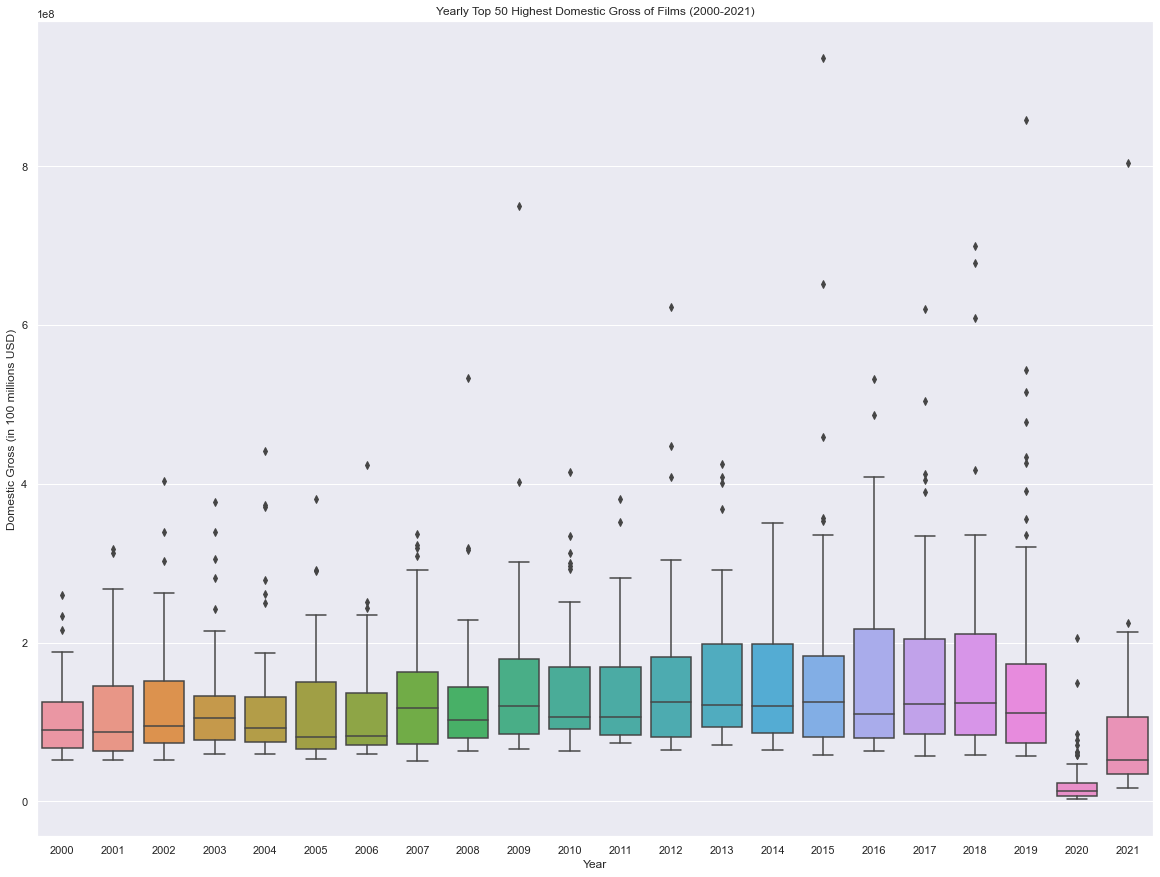

In [275]:

ax = sns.boxplot(x=movie_gross_table["Year Released"].astype('int64'), y=movie_gross_table["Gross_val"].astype('float64'), data=movie_gross_table)
ax.set_title('Yearly Top 50 Highest Domestic Gross of Films (2000-2021)')
ax.set_xlabel("Year")
ax.set_ylabel("Domestic Gross (in 100 millions USD)")
plt.show()


According to these box plots, we clearly see a trend emerge with most of the highest grossing movies. There also appear to be many lot of outliers above each box plot (by default seaborn separates outliers that fall outside 1.5*IQR from the upper and lower quartiles, which contains 99% of the data in a normal distribution). Along with that, the fourth and third quartiles are stretched and are proportionally larger than the 2 quartiles, which are tightly packed in most cases. This indicates that the films that gross the most are spread much further apart, and that makes sense, as typically, in any given year, there tend to be a select few of these films that return astonishing amounts of revenue. I would also like to mention the total range as the years go by increases dramatically, with the film's maximum values reaching greater sums of revenue during the 2010's but the minimums are also a bit less than before.

As previously mentioned in the introduction, many people have cited the influx of big-budget blockbuster films as the death of cinema, as typically these are the ones that gross the most. While in this graph we can't show that those films in particular are the outliers, we do notice that as the years progress, these outliers extend further and further away from the average. These extreme outliers represent films that gross record-breaking amounts, far above most other films that came out that year. The feeling that people are getting regarding the prevalence of these enormously popular films are definitely represented by the prevalence of these extreme outliers starting in the late 2000's.

Year Released
2000    1.052735e+08
2001    1.141660e+08
2002    1.268622e+08
2003    1.223636e+08
2004    1.261592e+08
2005    1.155511e+08
2006    1.146990e+08
2007    1.341019e+08
2008    1.307332e+08
2009    1.557715e+08
2010    1.427857e+08
2011    1.361647e+08
2012    1.556280e+08
2013    1.570118e+08
2014    1.487118e+08
2015    1.699109e+08
2016    1.655948e+08
2017    1.700748e+08
2018    1.741792e+08
2019    1.784170e+08
2020    2.692711e+07
2021    8.815415e+07
Name: Gross_val, dtype: float64


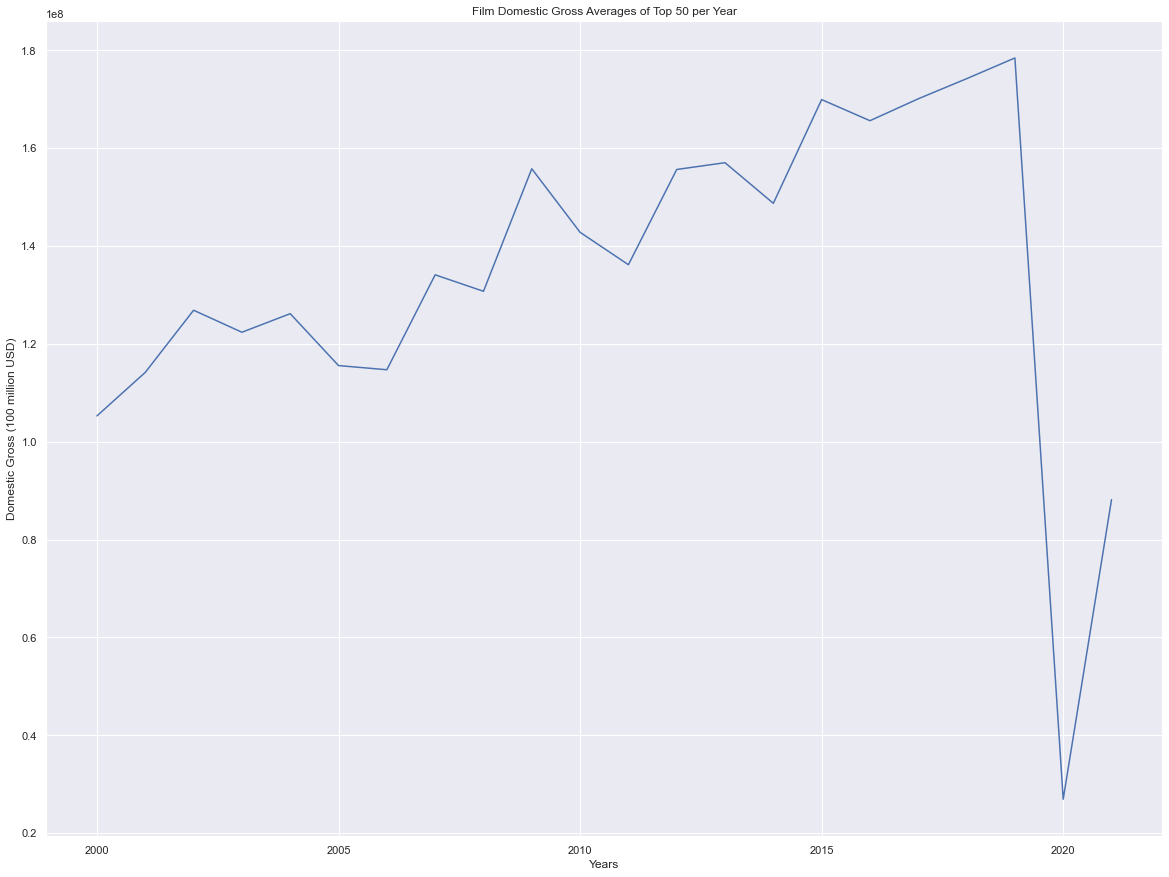

In [278]:
# calculating the means from above to more clearly represent them
gross_means = movie_gross_table.groupby("Year Released")["Gross_val"].mean()
print(gross_means)
ax = sns.lineplot(data=gross_means, x=gross_means.index, y=gross_means)
ax.set_title("Film Domestic Gross Averages of Top 50 per Year")
ax.set_ylabel("Domestic Gross (100 million USD)")
ax.set_xlabel("Years")
plt.show()

While it wasn't made clear in the box-plot, I wanted to show how the average domestic grosses of the Top 50 grossing films was increasing, seemingly showing that, from 2000-2019, the overall domestic gross of all films has been increasing and that going to the movies is only getting more popular. Unfortunately, these assumptions are stilted, as we haven't accounted for the inflation of the dollar and how that has affected ticket pricings.

Average ticket pricing for the movie theatres has been steadily increasing since 2000 due to this inflation. From [IMDB](https://help.imdb.com/article/imdbpro/industry-research/box-office-mojo-by-imdbpro-faq/GCWTV4MQKGWRAUAP#inflation), we are able to acquire these averages for each year, and we can notice that the price has has risen from $5.39 in 2000 to $9.37 in 2020. According to the Bureau of Labor Statistics, from 2000 to 2019, inflation has resulted in prices that are 1.48 times higher. During the same period, the average movie ticket price has increased by 1.67 times, so at a slightly faster rate than the inflation rate.

In order to truly gauge the popularity of films during this time period then, we have to normalize our data by dividing the total gross by the average ticket price of each year to arrive at an estimate for the total tickets sold to watch each film.

In [281]:
# Normaizing gross data with ticket pricing
for index, row in movie_gross_table.iterrows():
    #print(type(row['Year Released']))
    price = avg_tkt_price_usa.loc[str(row['Year Released'])].loc['Price_val']
    tkts_sold = row['Gross_val'] / price
    #print("{} / {} = {}".format(row['Gross_val'], price, tkts_sold))
    movie_gross_table.loc[index, 'Tickets Sold'] = tkts_sold 
    #print("Tickets Sold:",tkts_sold )

print(movie_gross_table[['Release', 'Year Released', 'Gross_val','Tickets Sold']].head(10))    

                          Release Year Released  Gross_val  Tickets Sold
0  How the Grinch Stole Christmas          2000  260044825  4.824579e+07
1                       Cast Away          2000  233632142  4.334548e+07
2          Mission: Impossible II          2000  215409889  3.996473e+07
3                       Gladiator          2000  187705427  3.482475e+07
4                 What Women Want          2000  182811707  3.391683e+07
5               The Perfect Storm          2000  182618434  3.388097e+07
6                Meet the Parents          2000  166244045  3.084305e+07
7                           X-Men          2000  157299718  2.918362e+07
8                     Scary Movie          2000  157019771  2.913168e+07
9               What Lies Beneath          2000  155464351  2.884311e+07


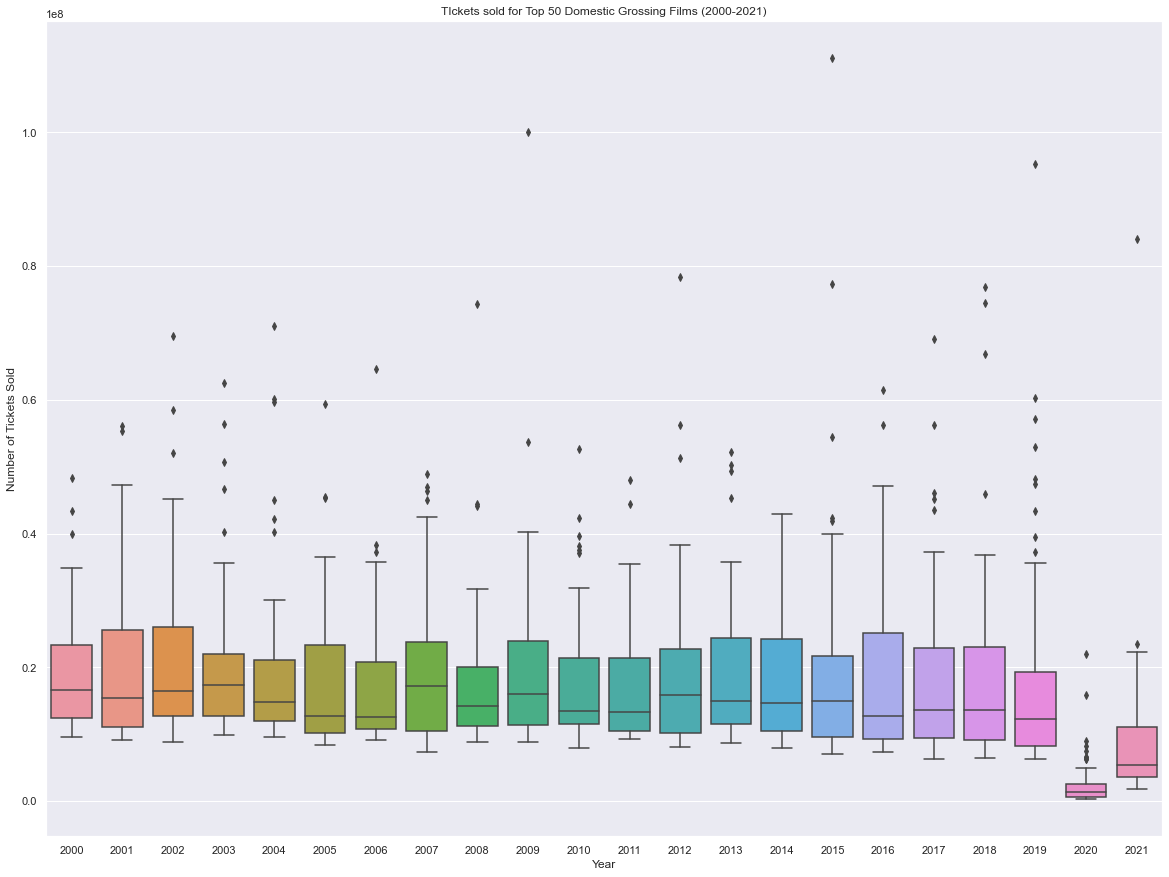

In [210]:
ax = sns.boxplot(x=movie_gross_table["Year Released"].astype('int64'), y=movie_gross_table["Tickets Sold"].astype('float64'), data=movie_gross_table)
ax.set_title('TIckets sold for Top 50 Domestic Grossing Films (2000-2021)')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Tickets Sold")
plt.show()

From this normalized plot, we can arrive at the same conclusions regarding the spread of the highest grossing films.

Year Released
2000    1.953126e+07
2001    2.017066e+07
2002    2.183514e+07
2003    2.029247e+07
2004    2.031548e+07
2005    1.802669e+07
2006    1.751129e+07
2007    1.949155e+07
2008    1.820796e+07
2009    2.076953e+07
2010    1.809704e+07
2011    1.717084e+07
2012    1.955126e+07
2013    1.931265e+07
2014    1.820218e+07
2015    2.015550e+07
2016    1.914391e+07
2017    1.896040e+07
2018    1.911956e+07
2019    1.980211e+07
2020    2.873758e+06
2021    9.211509e+06
Name: Tickets Sold, dtype: float64


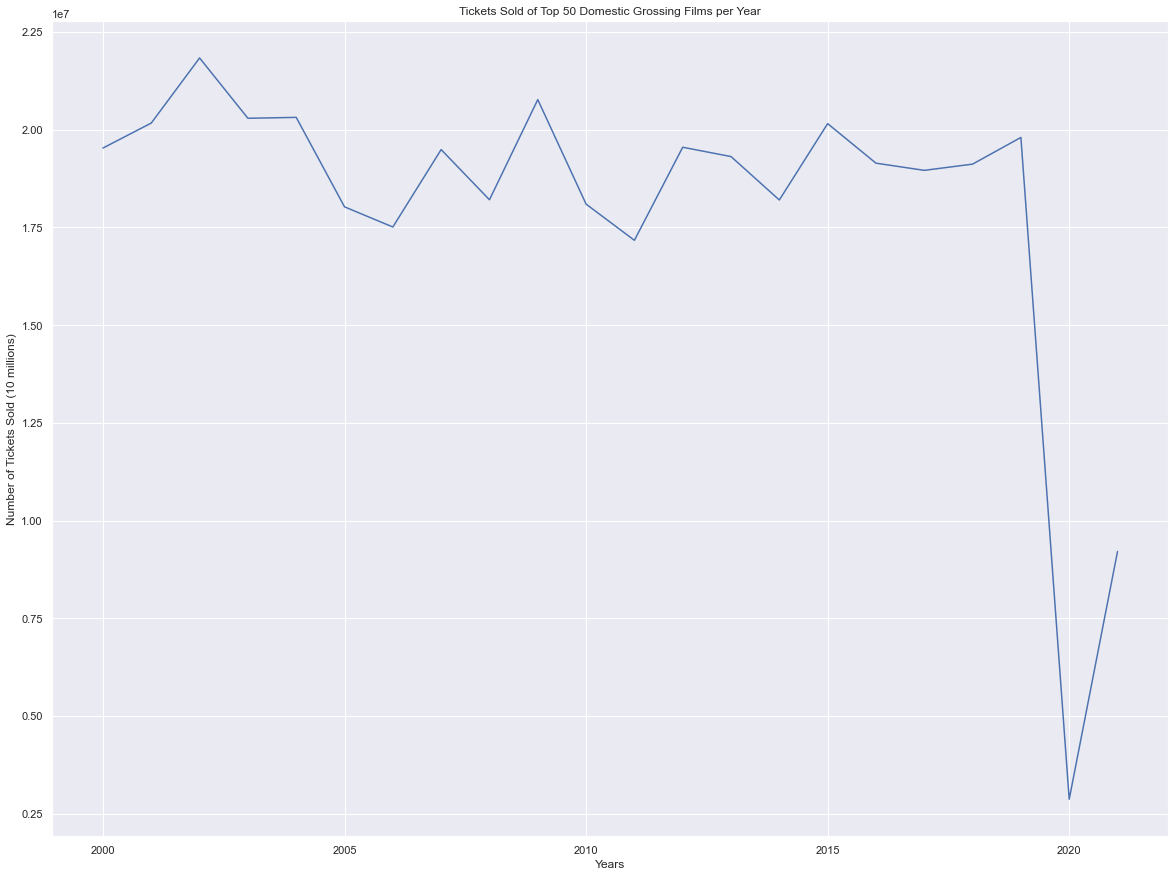

In [283]:
average_tickets_sold = movie_gross_table.groupby("Year Released")["Tickets Sold"].mean()
print(average_tickets_sold)
ax = sns.lineplot(data=average_tickets_sold, x=average_tickets_sold.index, y=average_tickets_sold)
ax.set_title("Tickets Sold of Top 50 Domestic Grossing Films per Year")
ax.set_ylabel("Number of Tickets Sold (10 millions)")
ax.set_xlabel("Year")
plt.show()

However, by looking at the average of each year, we notice that between 2000 and 2019, that number of tickets sold has stayed relatively stagnant, if not on a slight decline. With industry yearning for growth year upon year, graphs such as these would surely frighten many executives and investors currently in the film industry.

I can also mention now the impact of the COVID-19 pandemic, which was led to a decline that not many projections would have predicted otherwise. With such a massive and sudden decrease in revenue in 2020 and already an ongoing slow decline in industry interest throughout the millenium, it is no wonder that so many theatres, especially those that are smaller and independant, had to close down for good.

## Hypothesis Testing

Since we want to find out what kinds of films have been dominant over the years, I want to start by paying attention to the supposed "quality" of these films, specifically by looking at critic data. We've already scraped the critic review scores off of Rotten Tomatoes. We are going to see if there is a correlation between a positive review score and a better return at the box office. I also color the points by their budget classification, whether it is a Big Budget, as in your typical blockbuster, which has a budget of upwards of $75 million, a Low-Budget film, typically an independent film with a budget of less than $15 million, and finally a mid-budget film, between those two values. Learn more about these types of films [here](https://www.cnn.com/2022/02/26/entertainment/mid-budget-movie-decline-cec/index.html).

In [284]:
movie_gross_table_n = movie_gross_table.dropna(subset=['rt_score', 'Budget'])
#movie_dict = movie_gross_table_n.set_index('id').to_dict()

# Color coding points
for index, row in movie_gross_table_n.iterrows():
    if row['Budget_class'] == 'Big':
        movie_gross_table_n.loc[index, 'point_color'] = 'Red'
    elif row['Budget_class'] == 'Mid':
        movie_gross_table_n.loc[index, 'point_color'] = 'Blue'
    elif row['Budget_class'] == 'Low':
        movie_gross_table_n.loc[index, 'point_color'] = 'Green'
    else:
        movie_gross_table_n.loc[index, 'point_color'] = 'Gray'

    if row['rt_score'] >= 60:
        movie_gross_table_n.loc[index, 'fresh_color'] = 'Red'
    else:
        movie_gross_table_n.loc[index, 'fresh_color'] = 'Green'

#print(all_budgets_table)

C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\323297809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_gross_table_n.loc[index, 'point_color'] = 'Red'
C:\Users\Owner\AppData\Local\Temp\ipykernel_15404\323297809.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_gross_table_n.loc[index, 'fresh_color'] = 'Green'


Here we are making a set of linear regression models for each year.

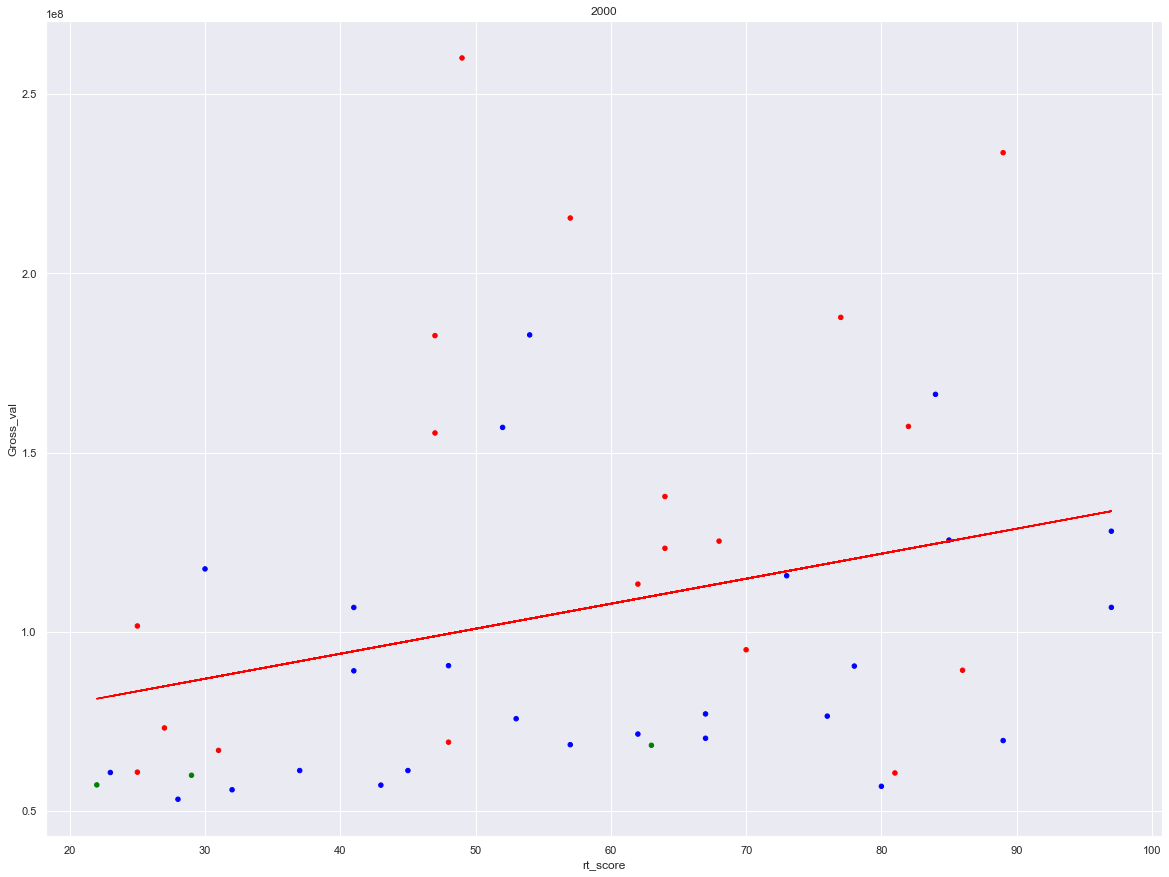

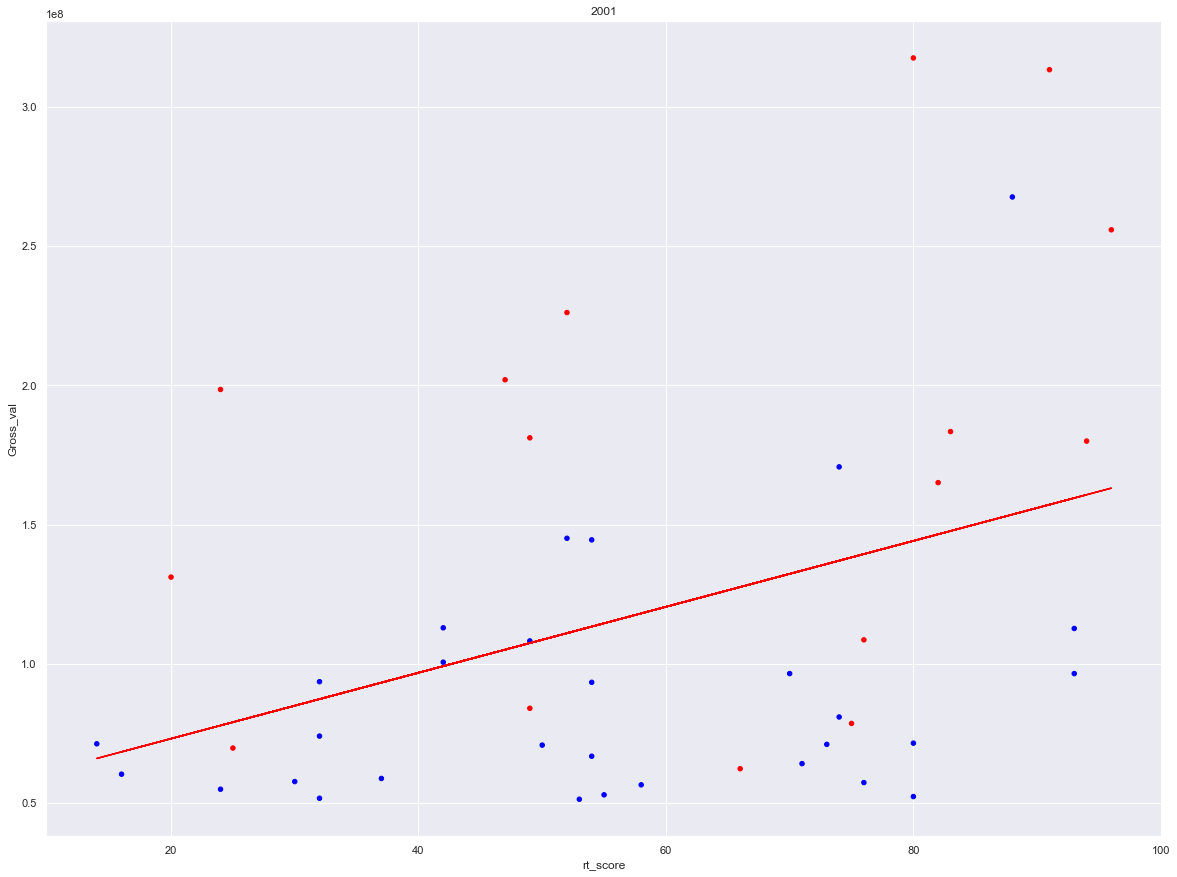

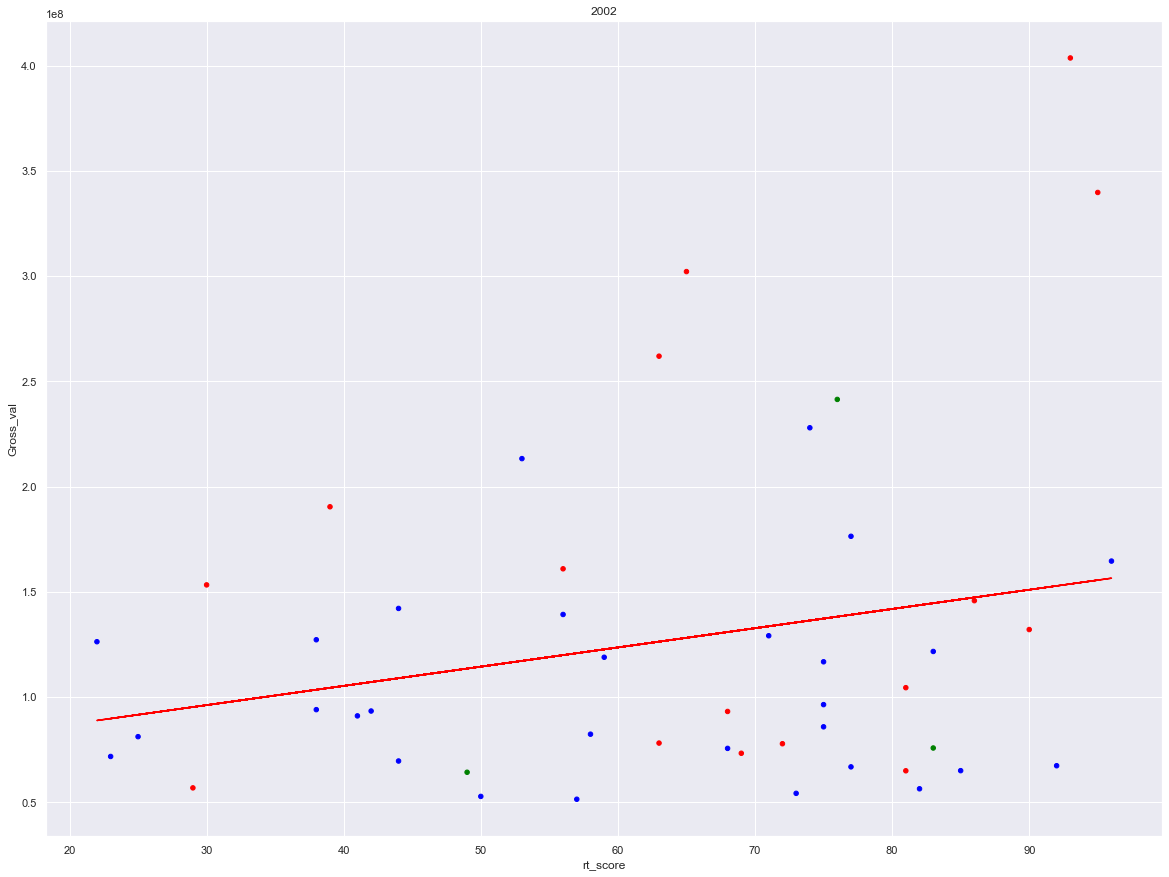

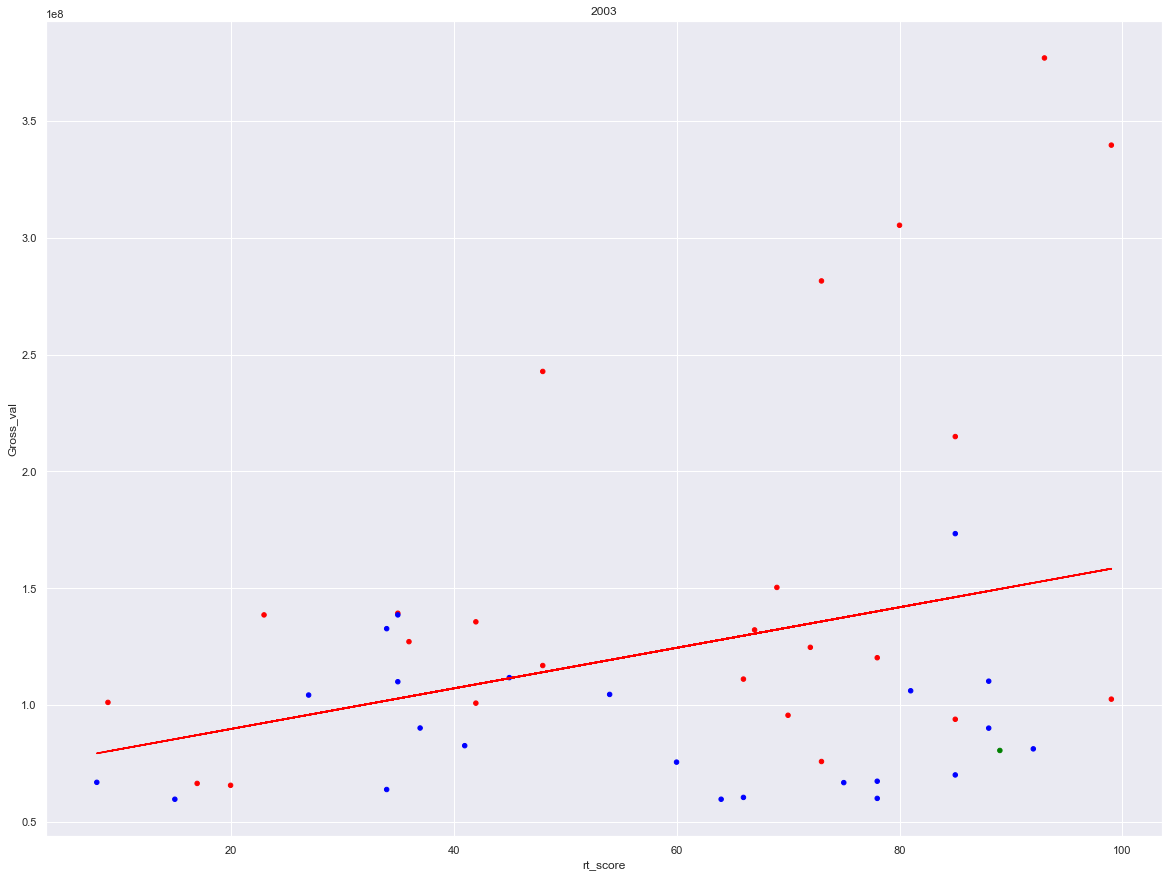

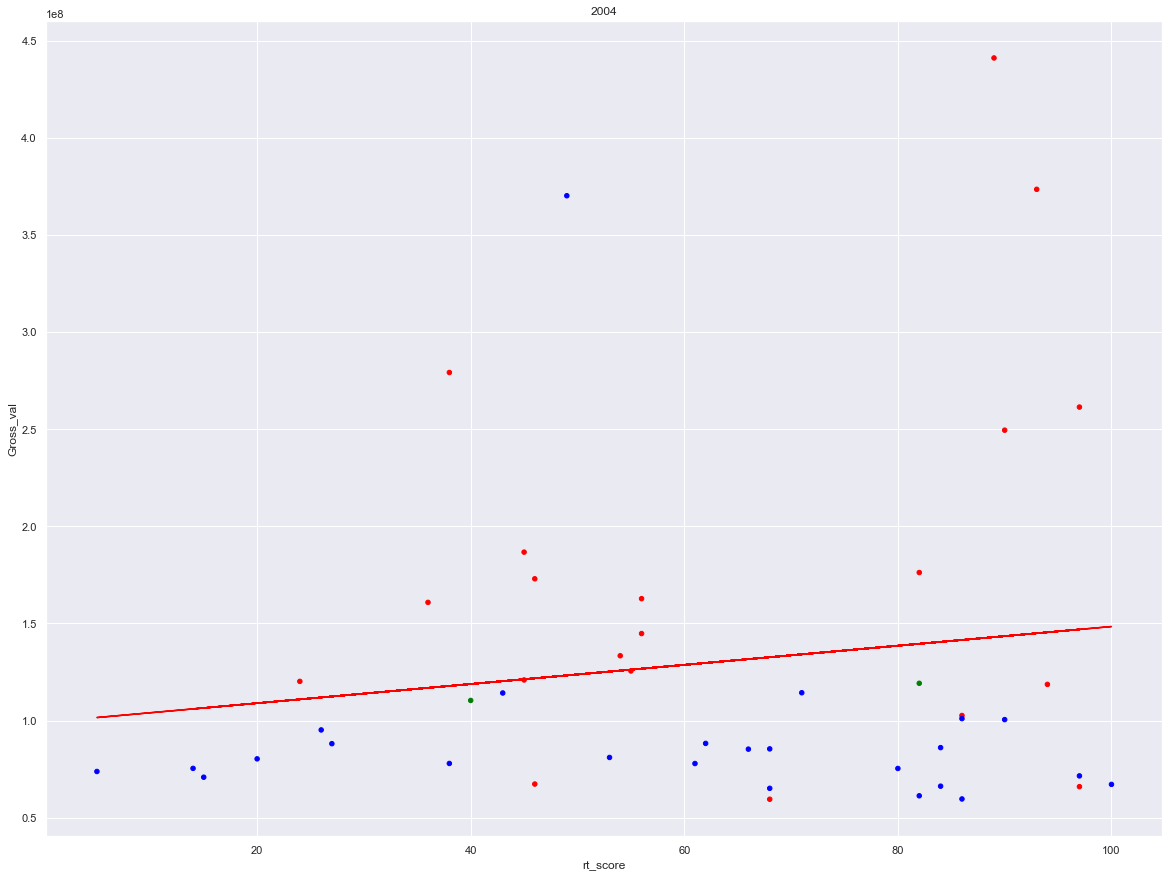

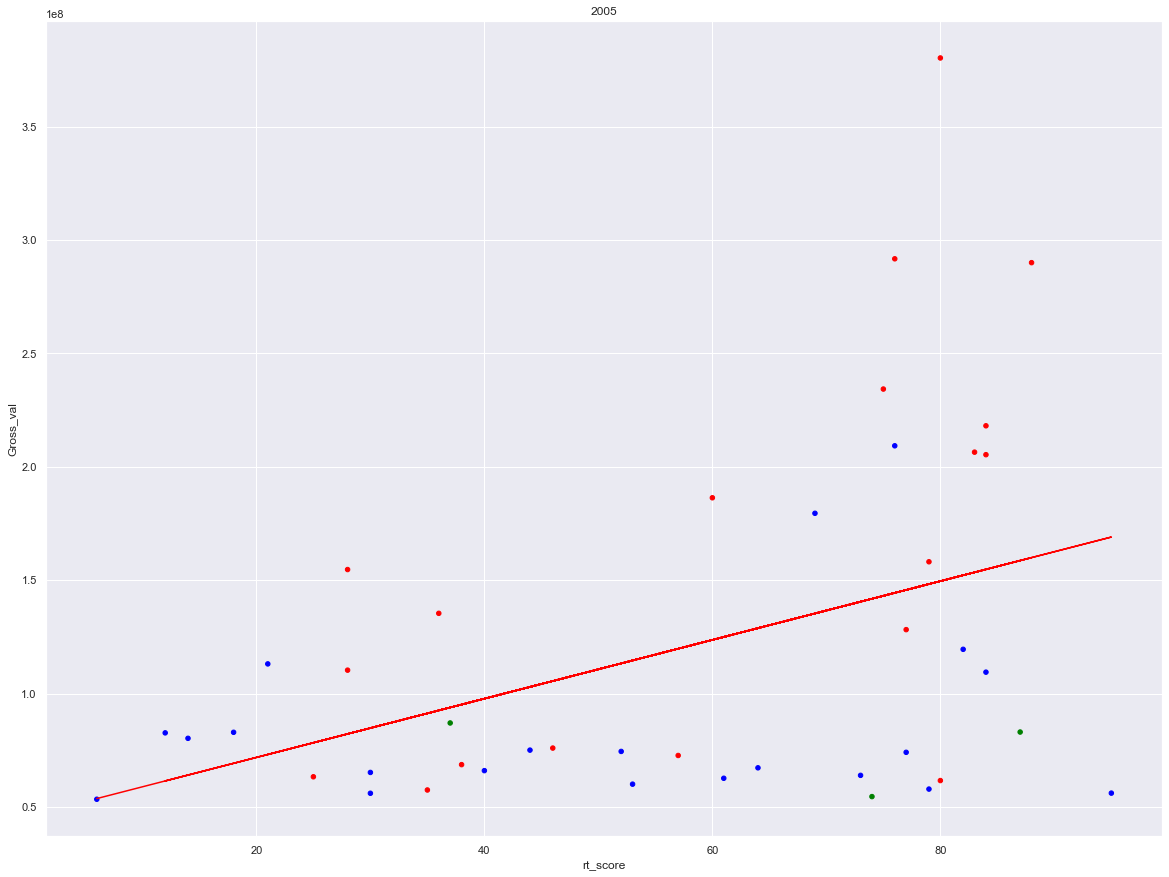

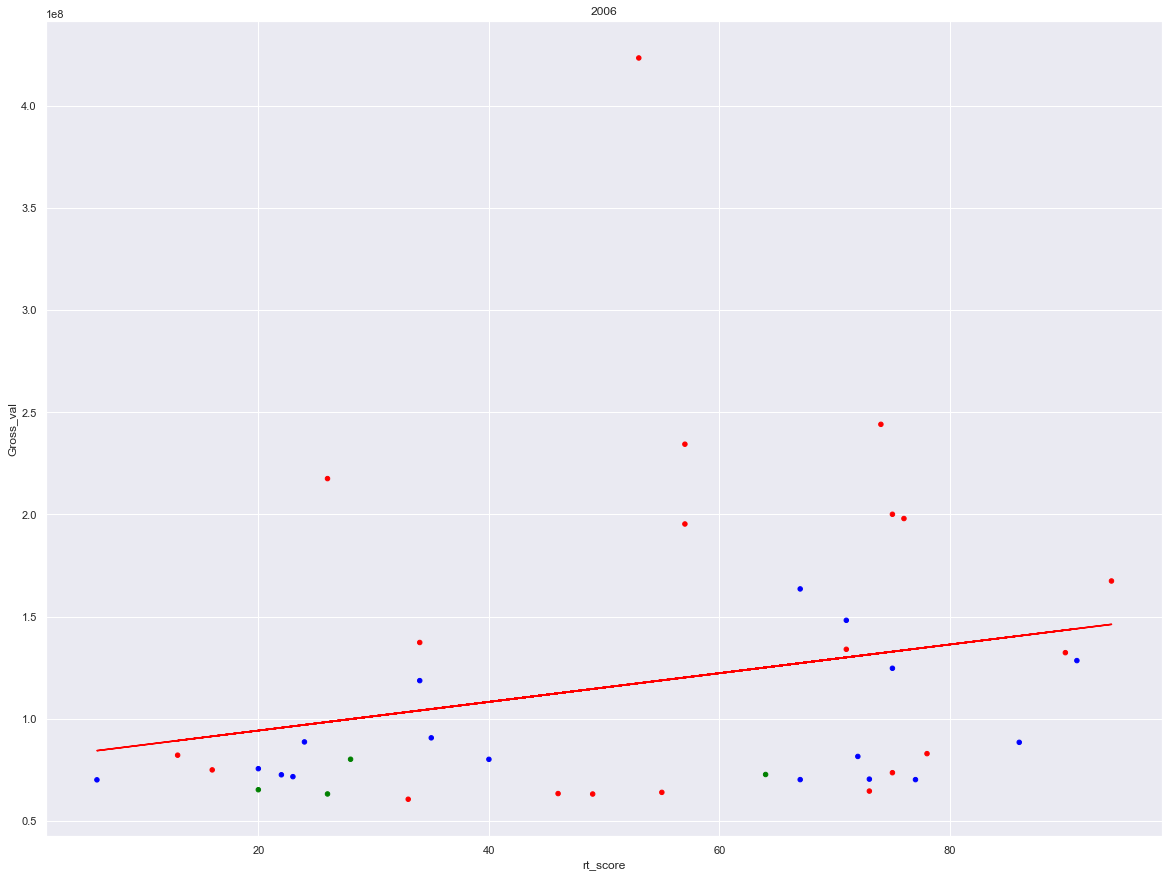

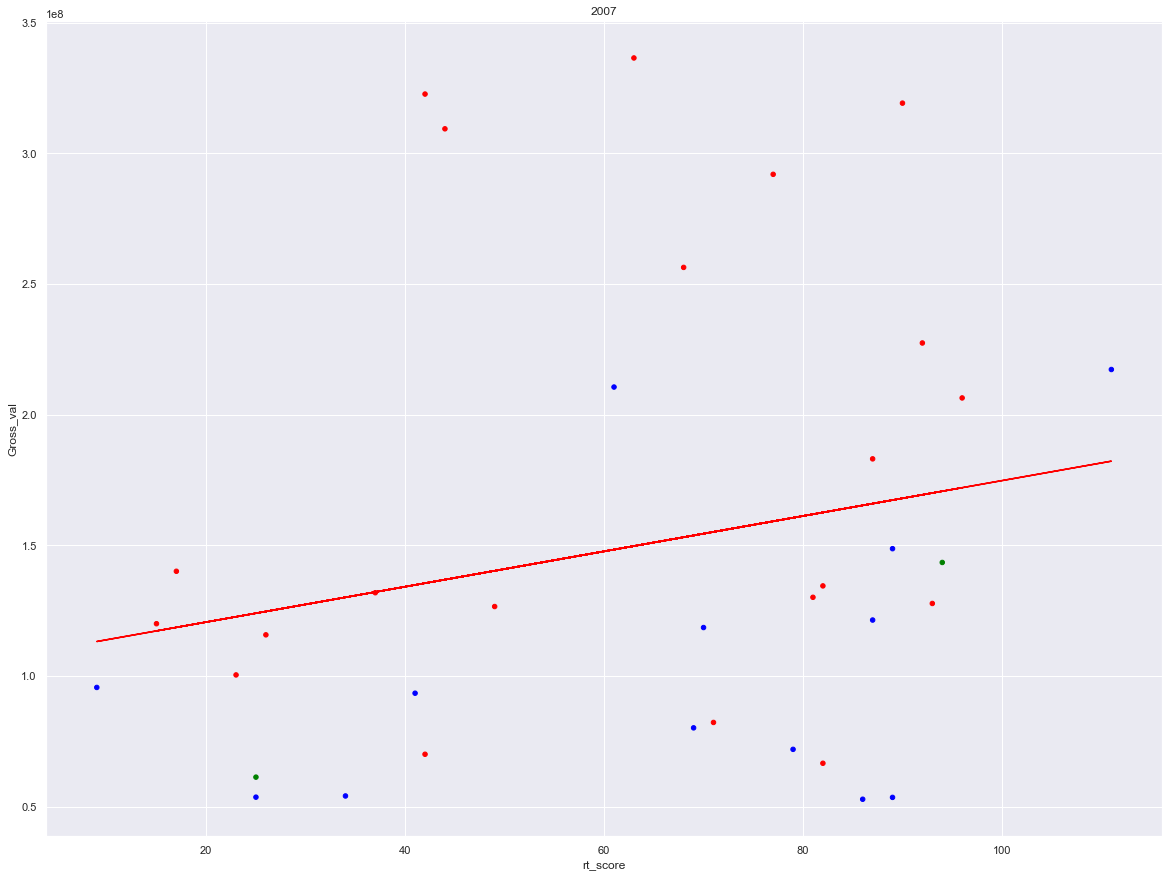

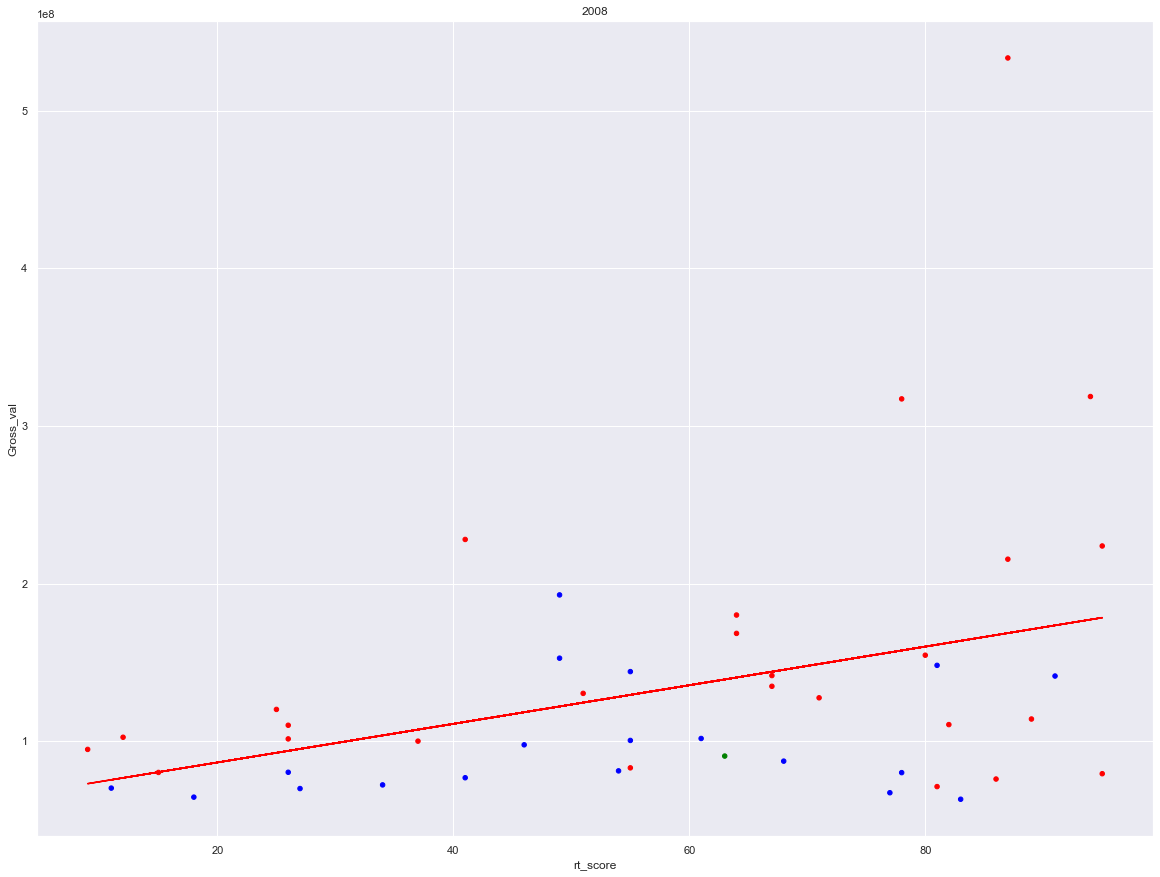

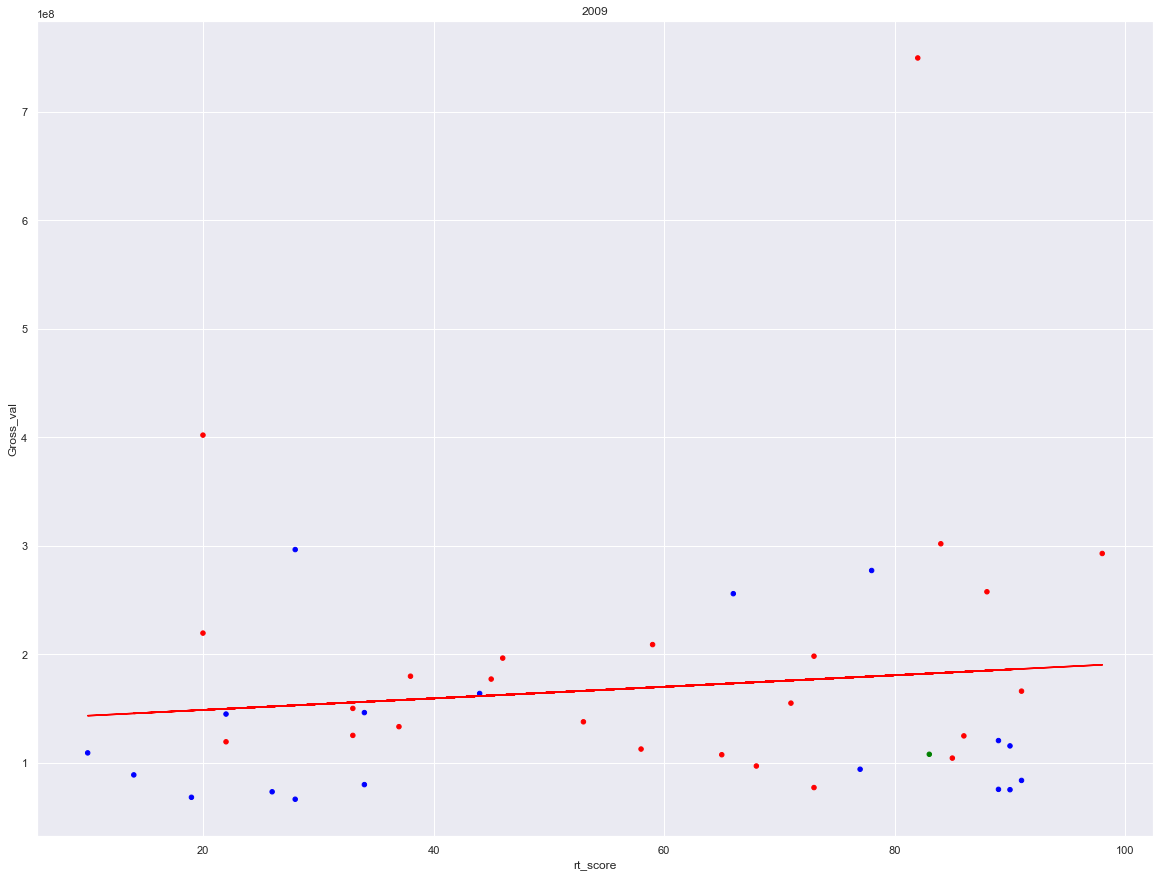

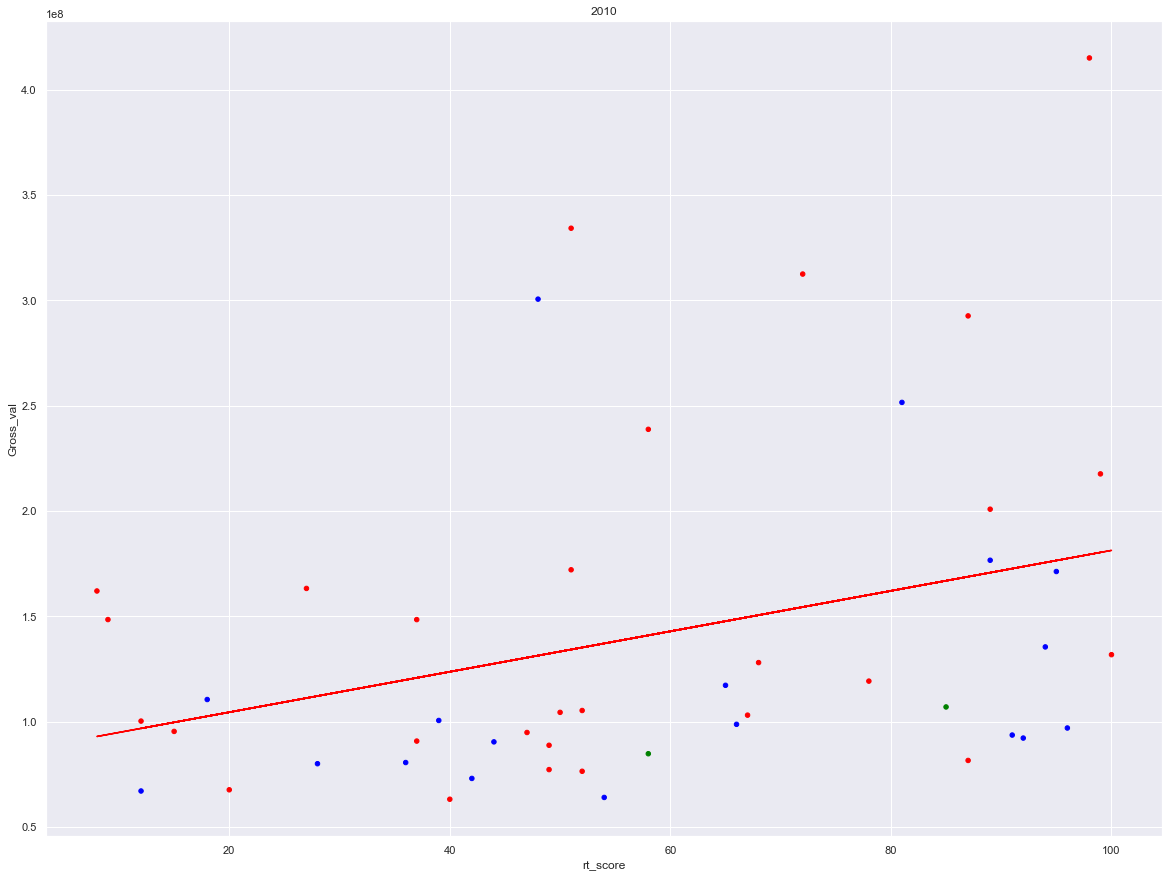

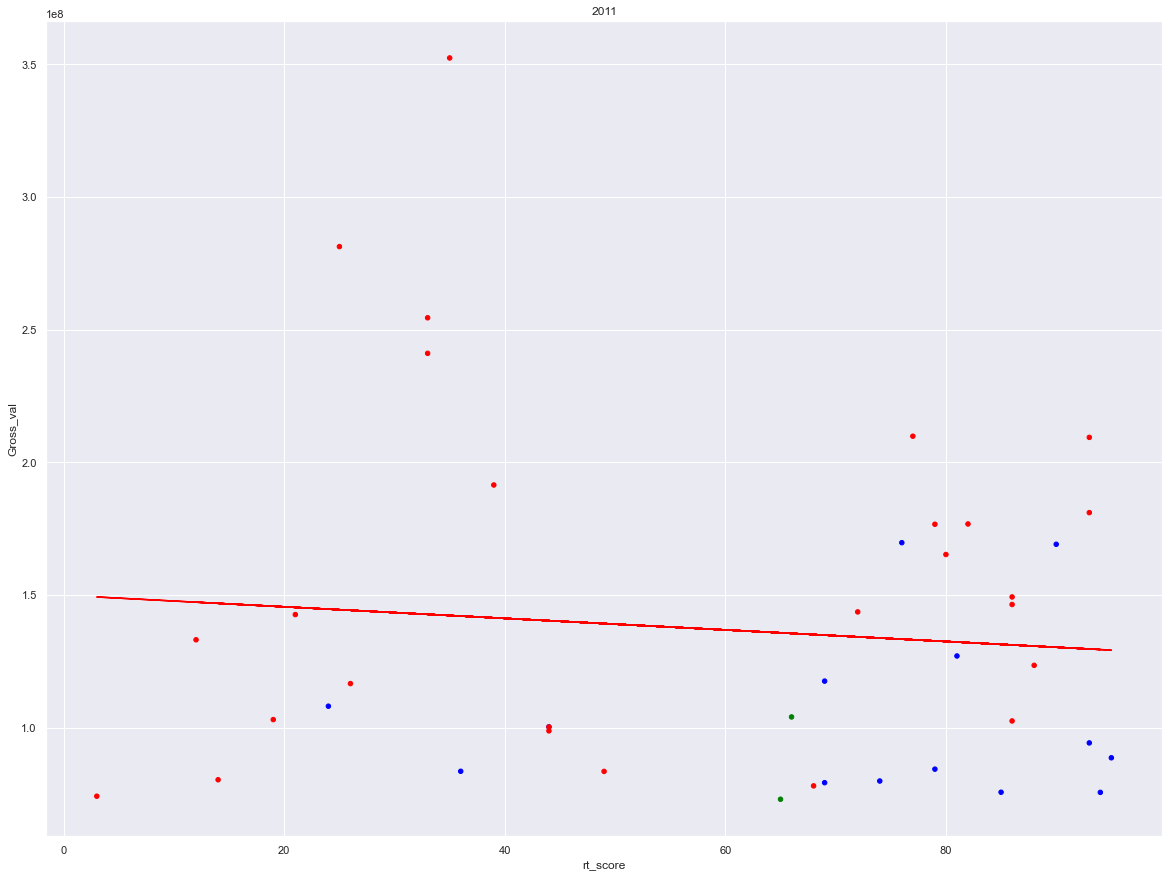

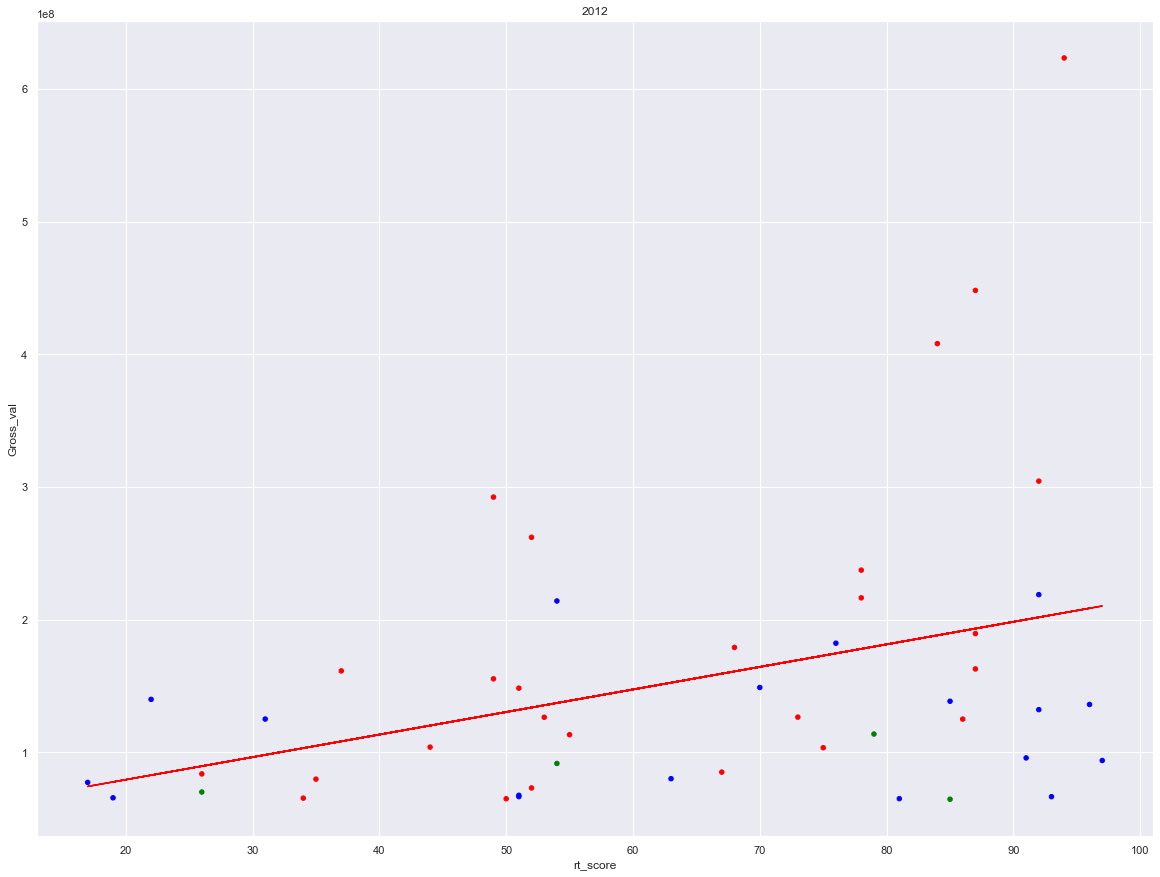

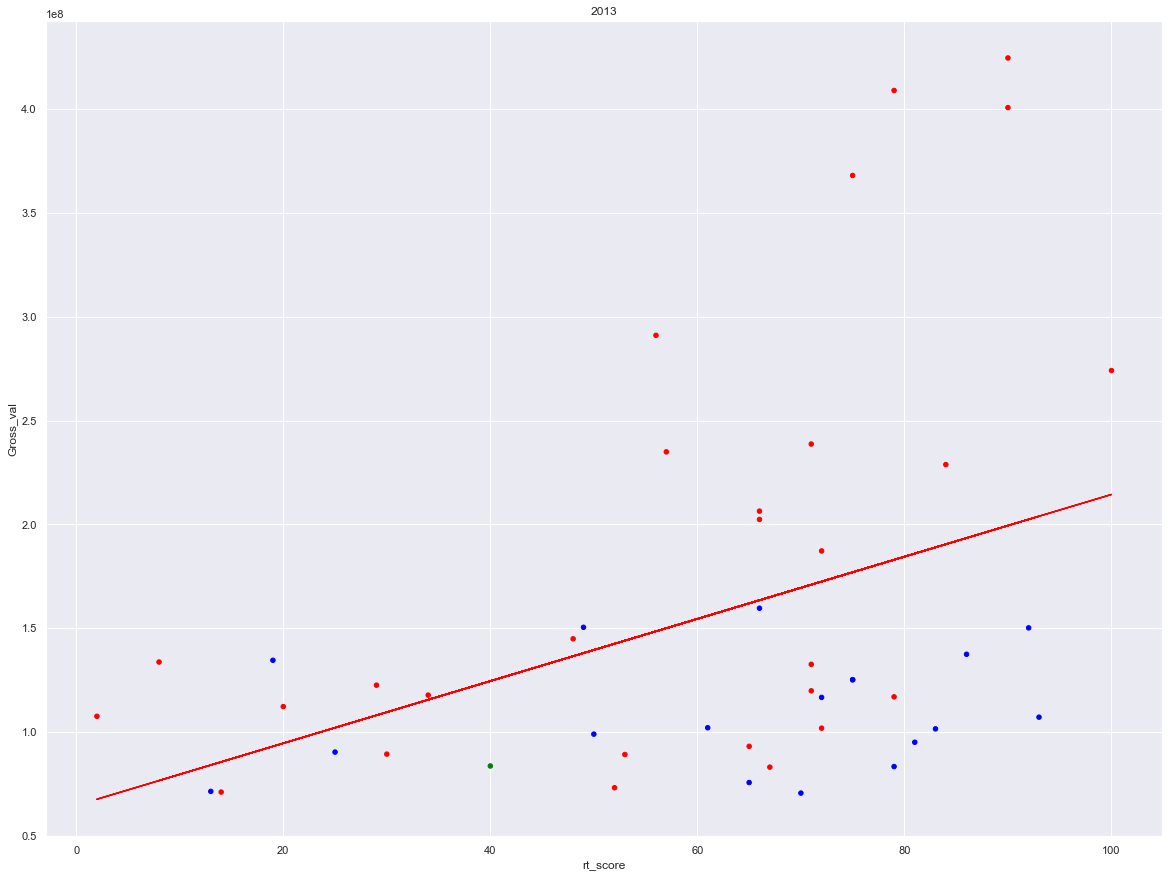

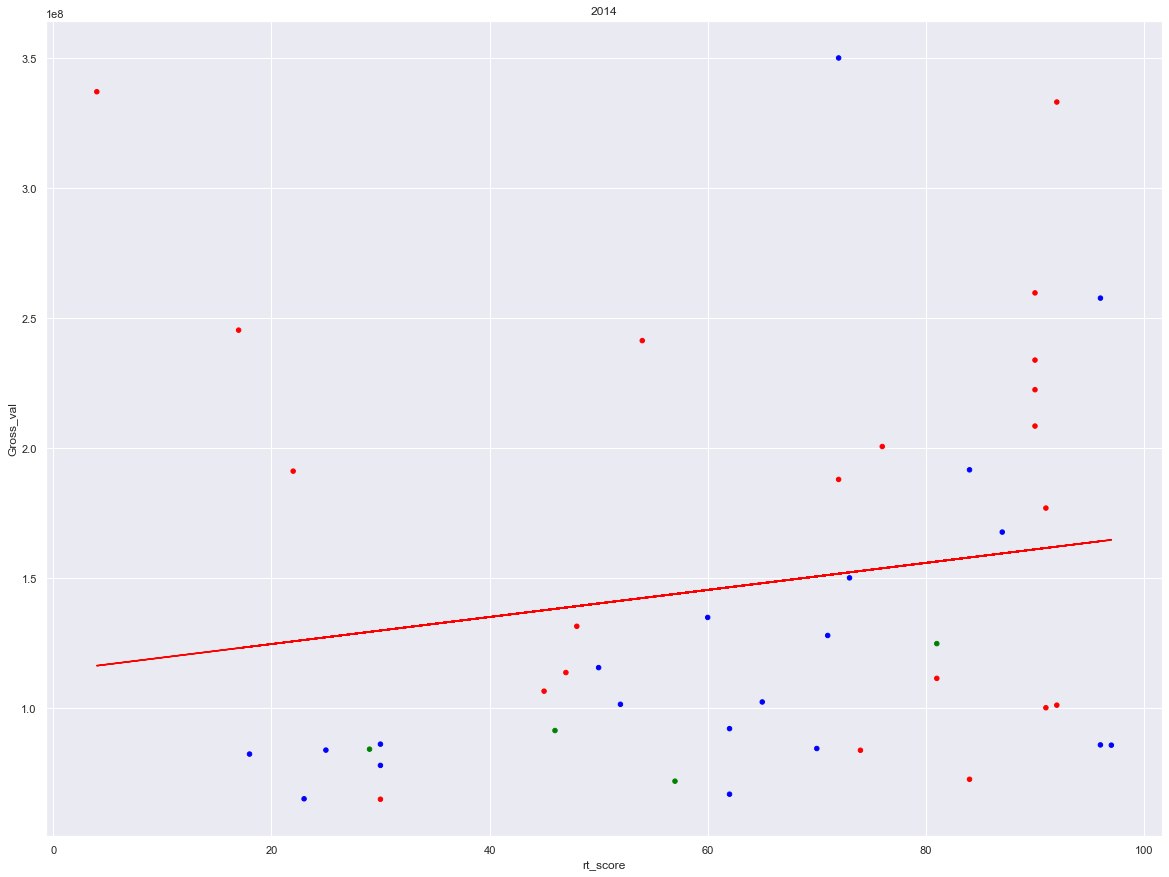

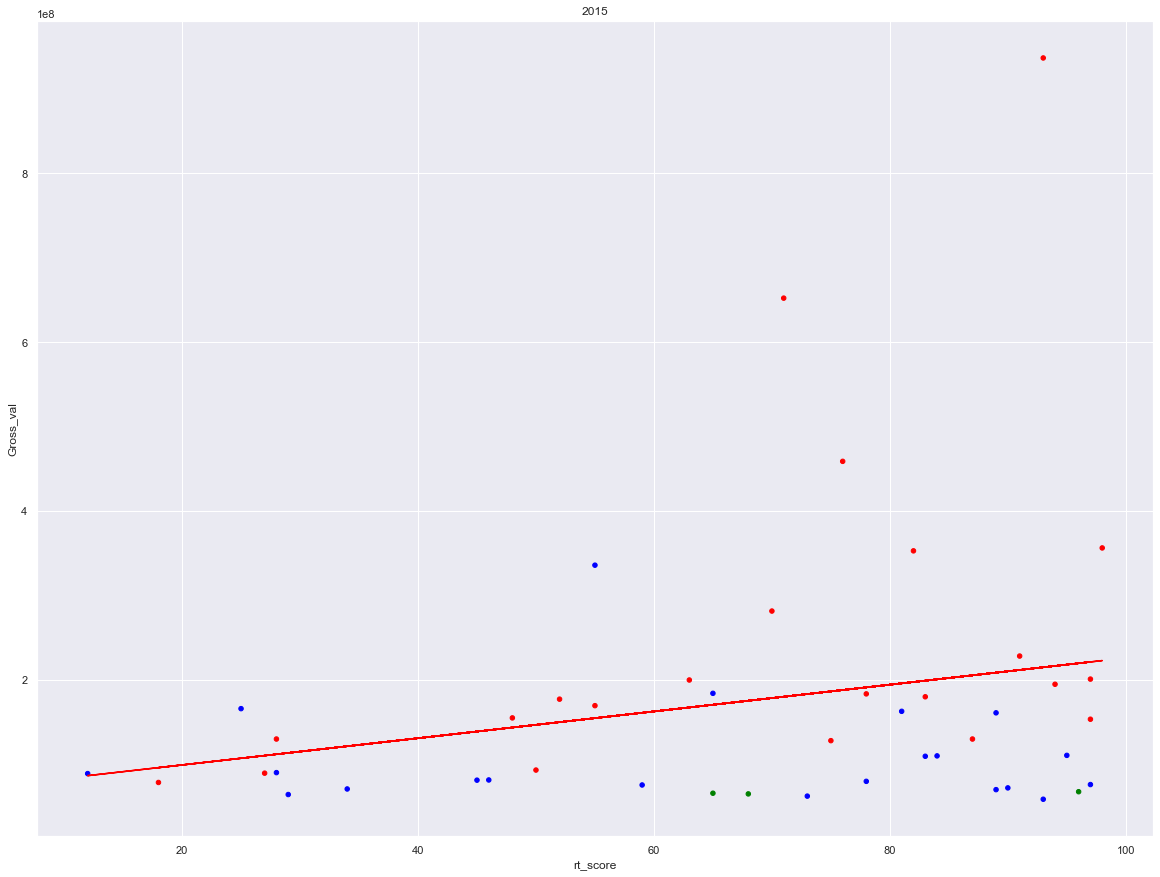

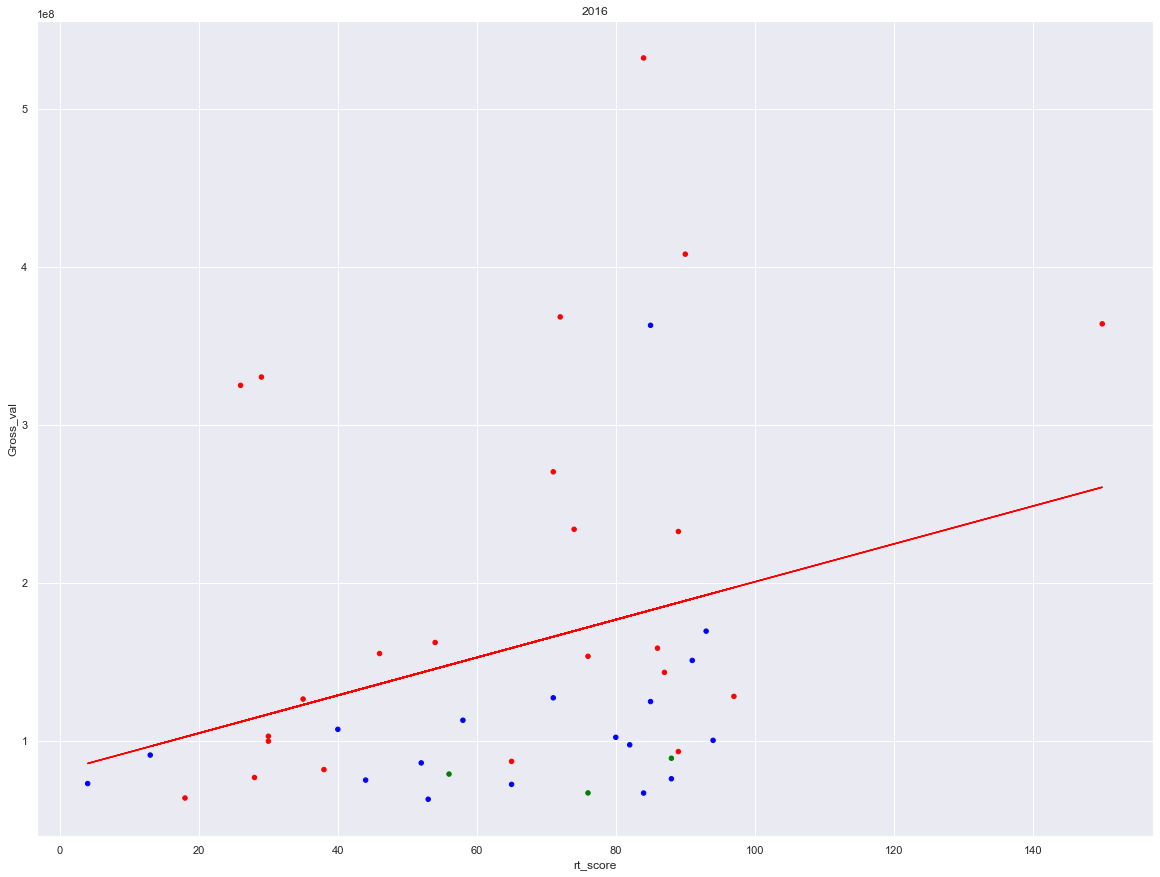

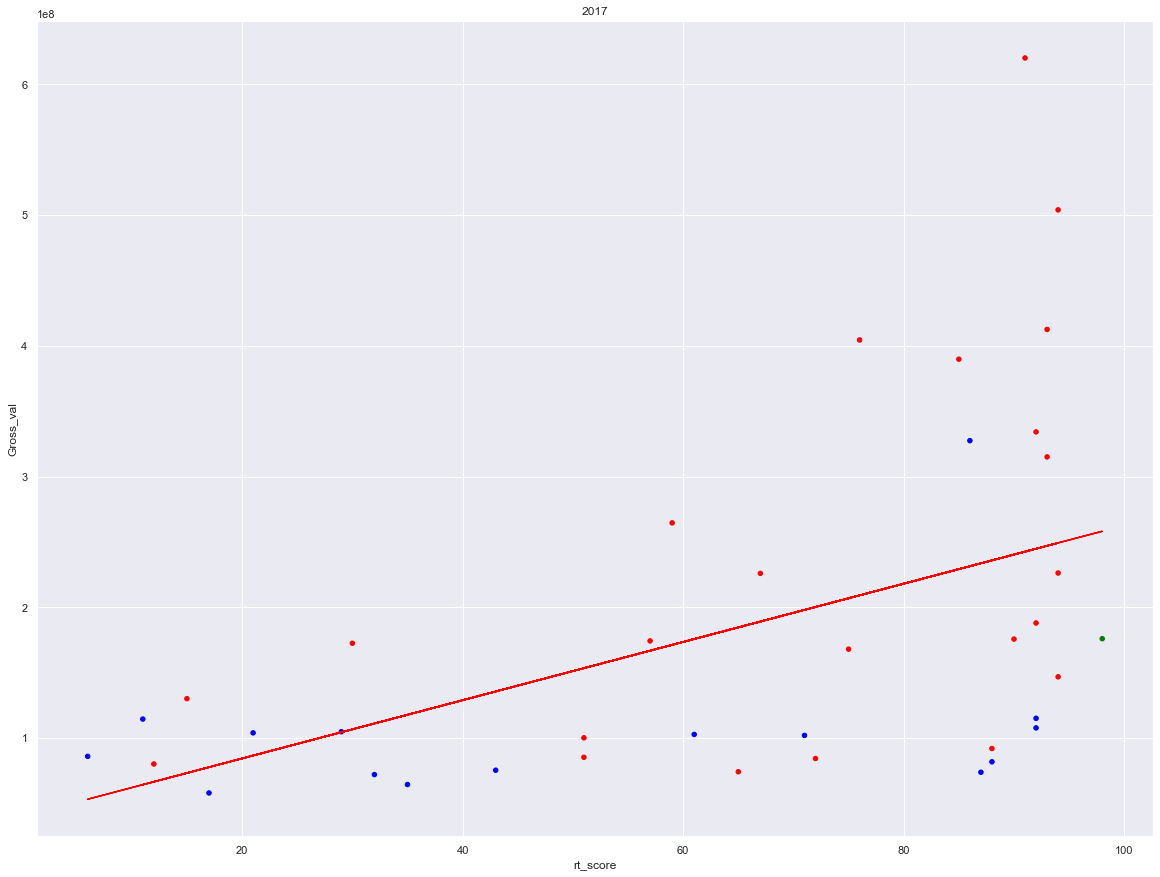

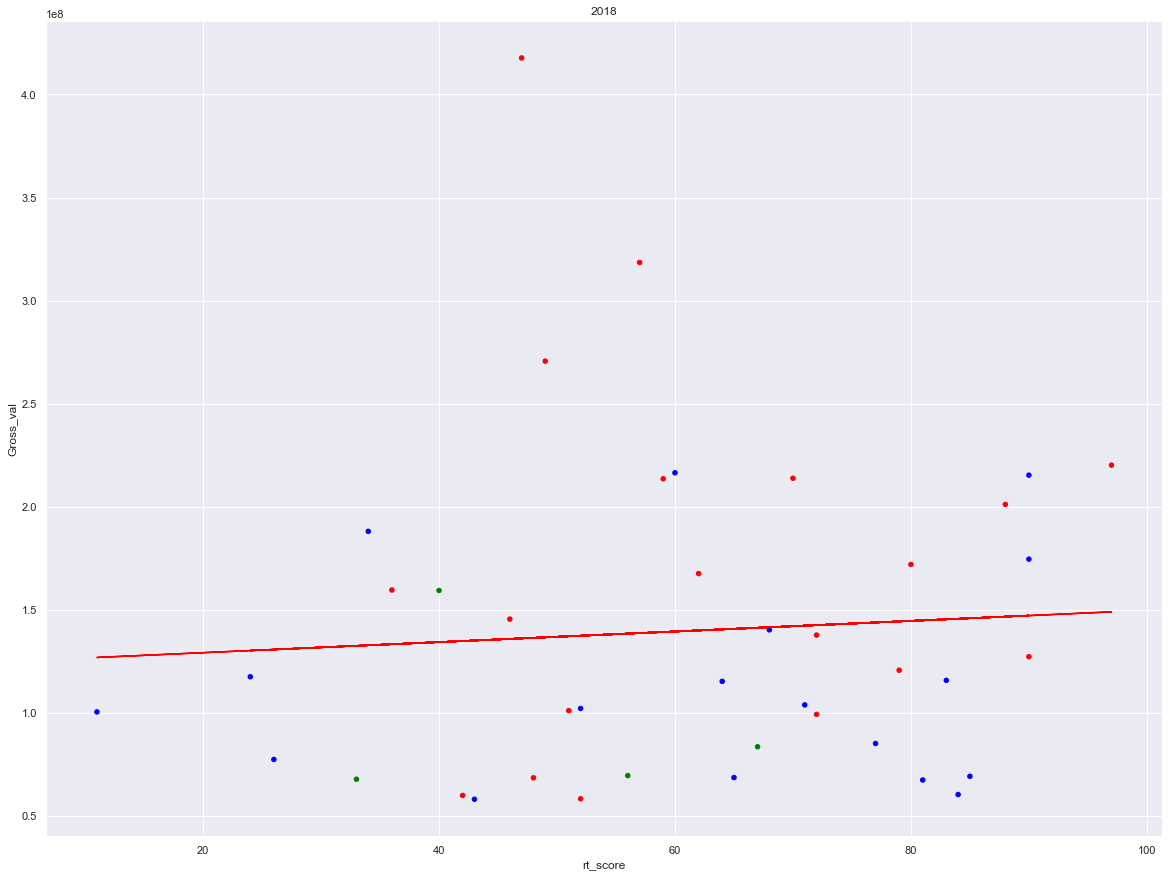

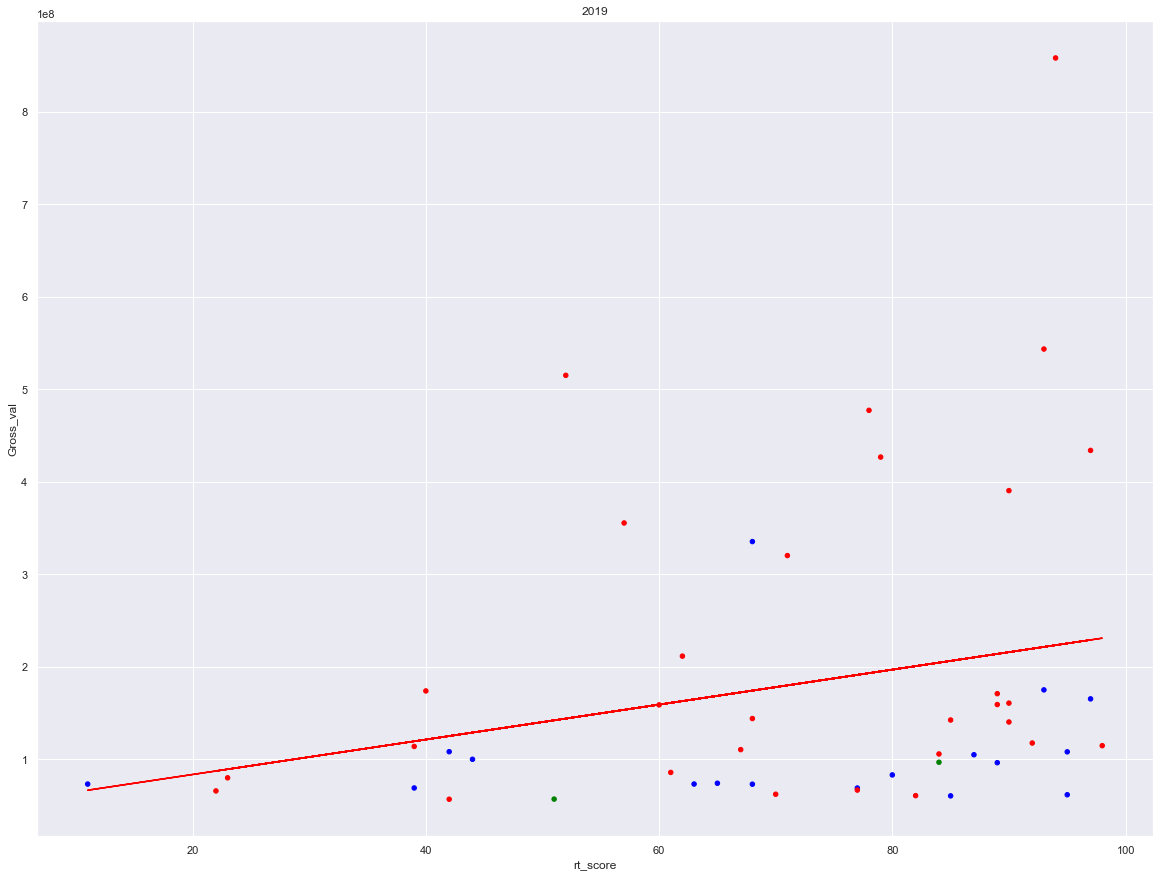

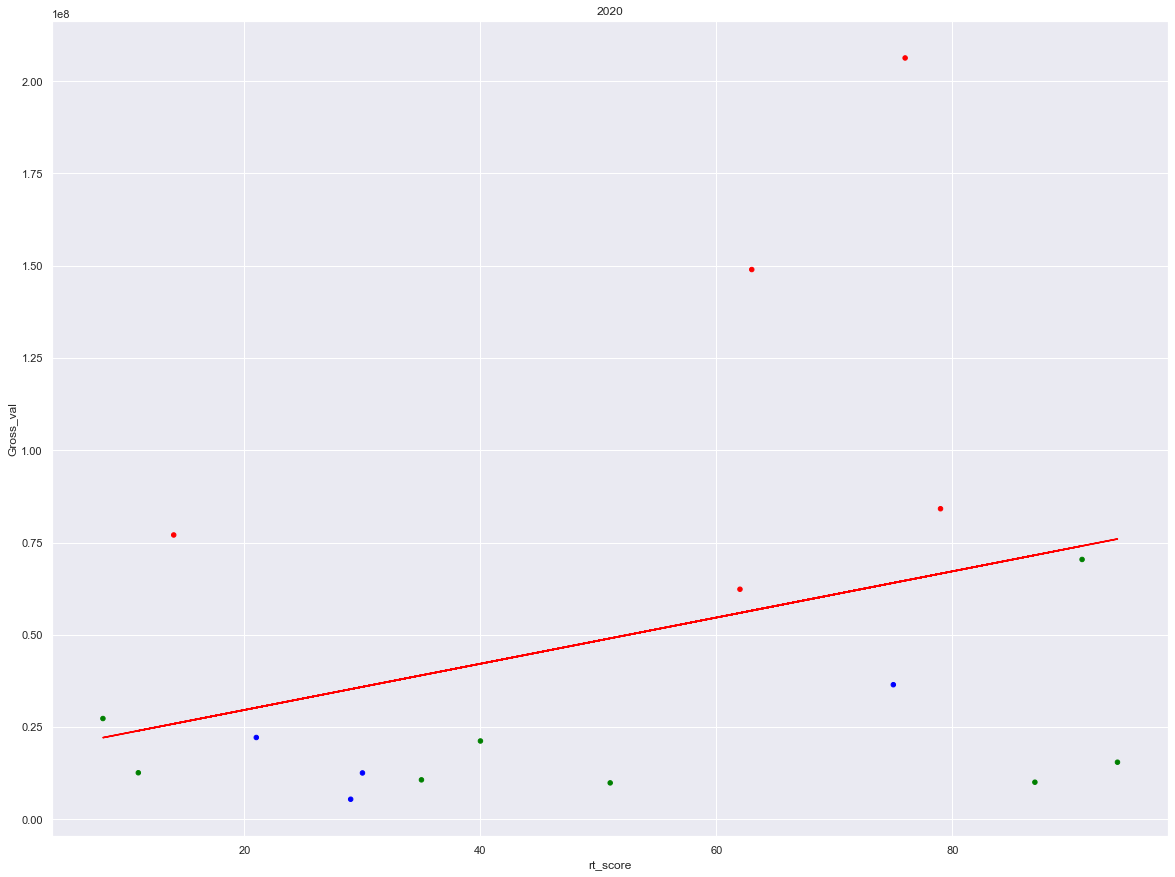

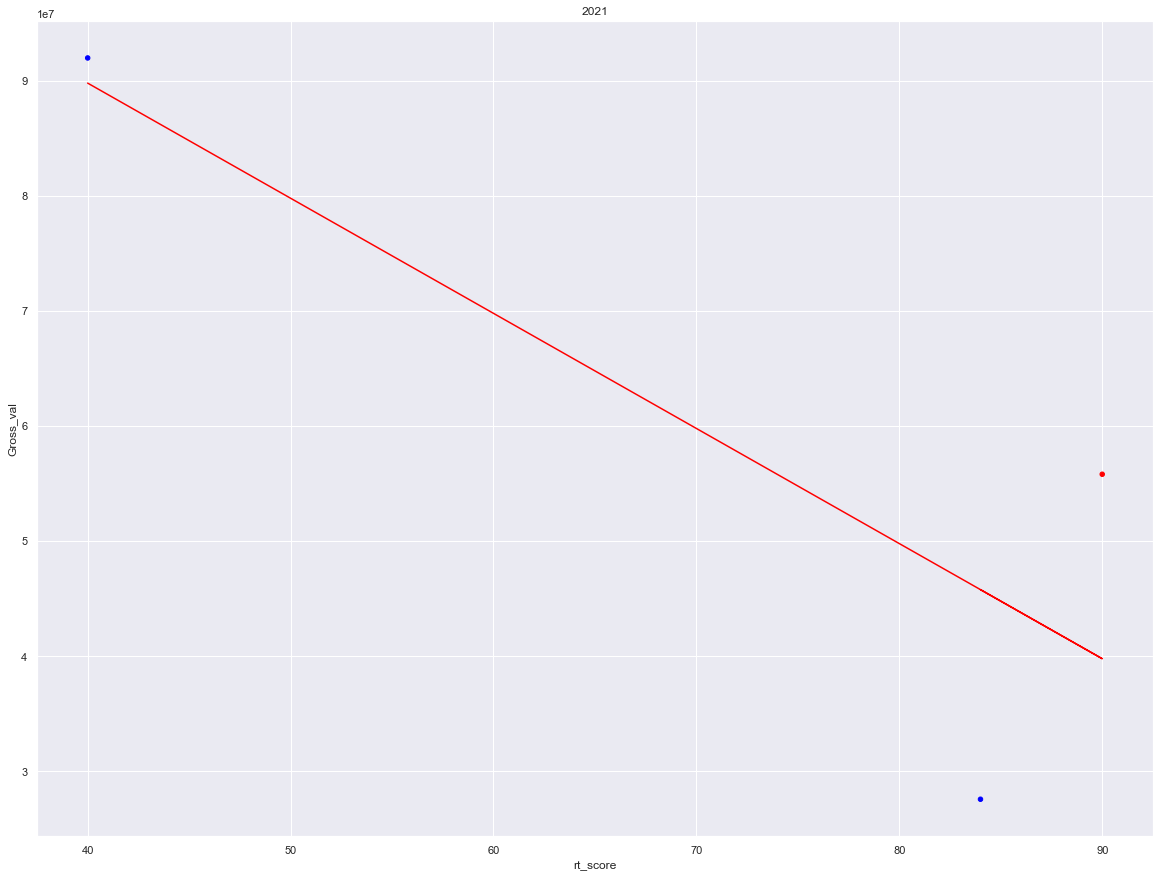

In [320]:
r_scores = dict()
years = movie_gross_table_n['Year Released'].unique()

# Taking R_scores of first set of scatterplots, on review score
for yr in years:
    data = movie_gross_table_n.loc[movie_gross_table_n['Year Released'] ==  yr]
    data.plot.scatter(x='rt_score', y='Gross_val', title=yr, color=data['point_color'])
    X = data.loc[:, 'rt_score'].values.reshape(-1, 1)
    Y = data.loc[:, 'Gross_val'].values.reshape(-1, 1)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    r_scores[yr] = linear_regressor.score(X, Y)
 
    plt.plot(X, Y_pred, color='red')




In [256]:
print("The Coefficient of determinations (R^2) for Highest grossing films from 2000-2021 in respect to their Rotten Tomato score")
for k, v in r_scores.items():
    print("{}: {}".format(k,v))

The Coefficient of determinations (R^2) for Highest grossing films from 2000-2021 in respect to their Rotten Tomato score
2000: 0.06611205645964424
2001: 0.14738469686293865
2002: 0.051282137218645274
2003: 0.10054565171542318
2004: 0.0324732724770167
2005: 0.1764226846640331
2006: 0.06879070587145741
2007: 0.027155966150107957
2008: 0.13187066013132187
2009: 0.015586749911360998
2010: 0.11801123327664154
2011: 0.0007832776408537301
2012: 0.12612092840735978
2013: 0.1772669600955753
2014: 0.019940921759339814
2015: 0.0623228204778945
2016: 0.14373001421745224
2017: 0.18679902778883017
2018: 0.11339266897138778
2019: 0.06445951746968437
2020: 0.008043514369989957
2021: 0.05943688634657973


As we can see, there isn't really a strong correlation between Rotten Tomato score and the final gross. Sure, there is some correlation, which gives credence to the fact that most moviegoers would rather go to a film that has been better received by critics, but because there are so many outliers, we can really not arrive at conclusive evidence.

In the next set of scatter plots, I will plot and produce a linear model to demonstrate the relationship between domestic gross and budget. I also decided to color these points by their review on Rotten Tomatoes, whether the film received a "Fresh" or "Rotten" aggregate score. A "Fresh" score is where at least 60% of critics gave the film a positive review. 

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


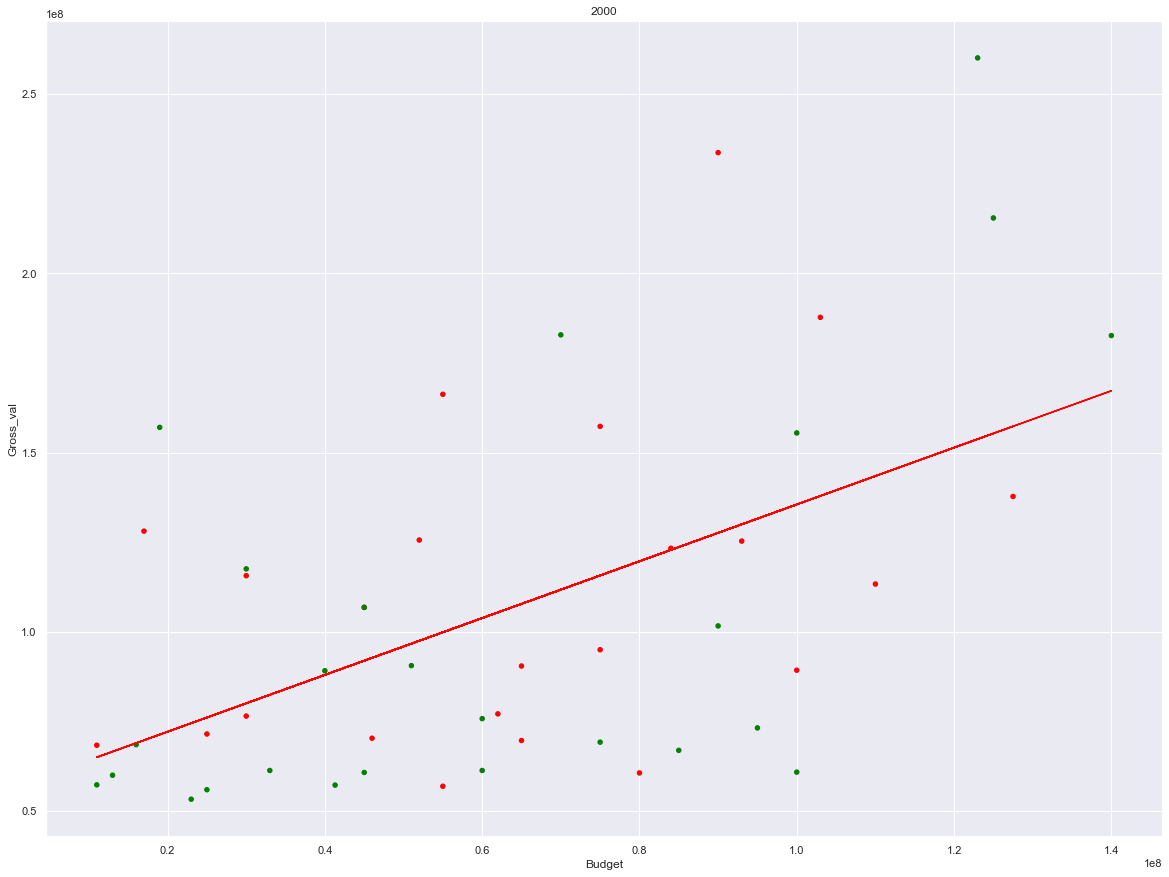

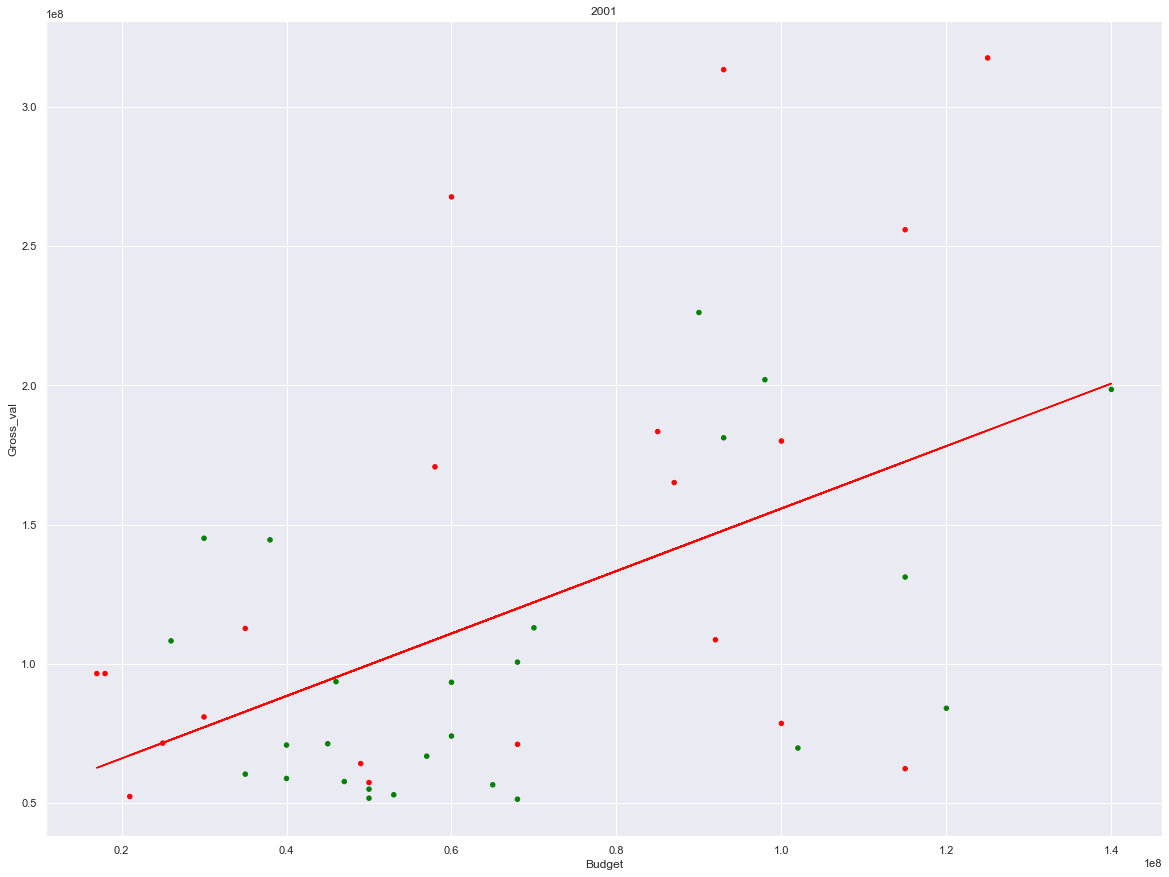

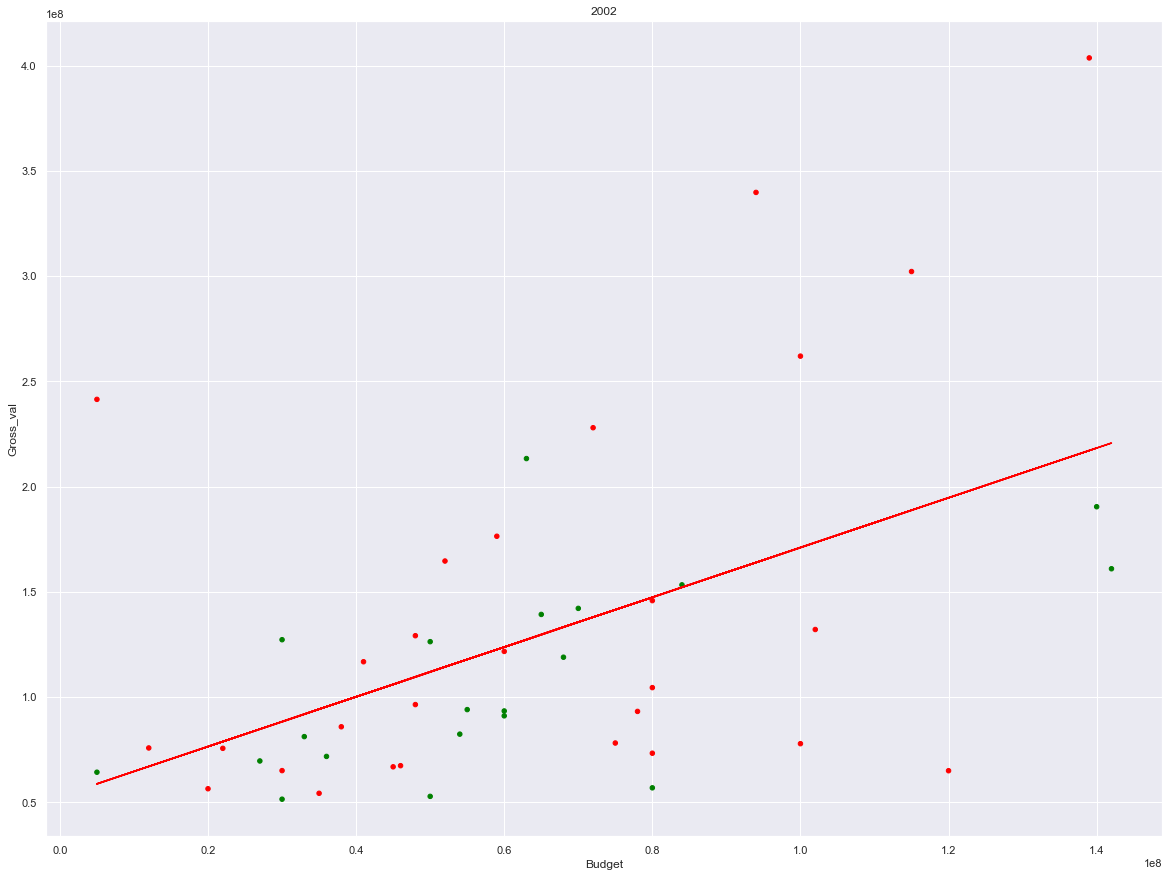

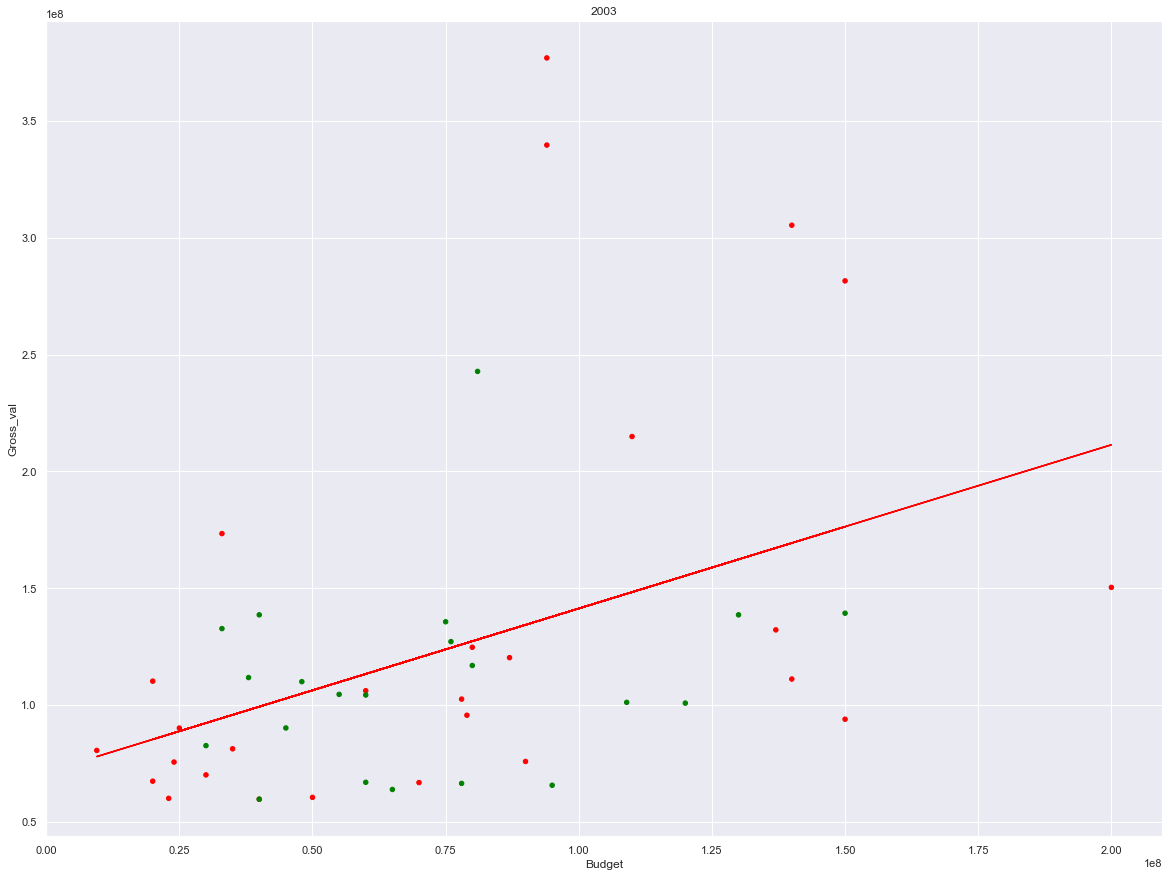

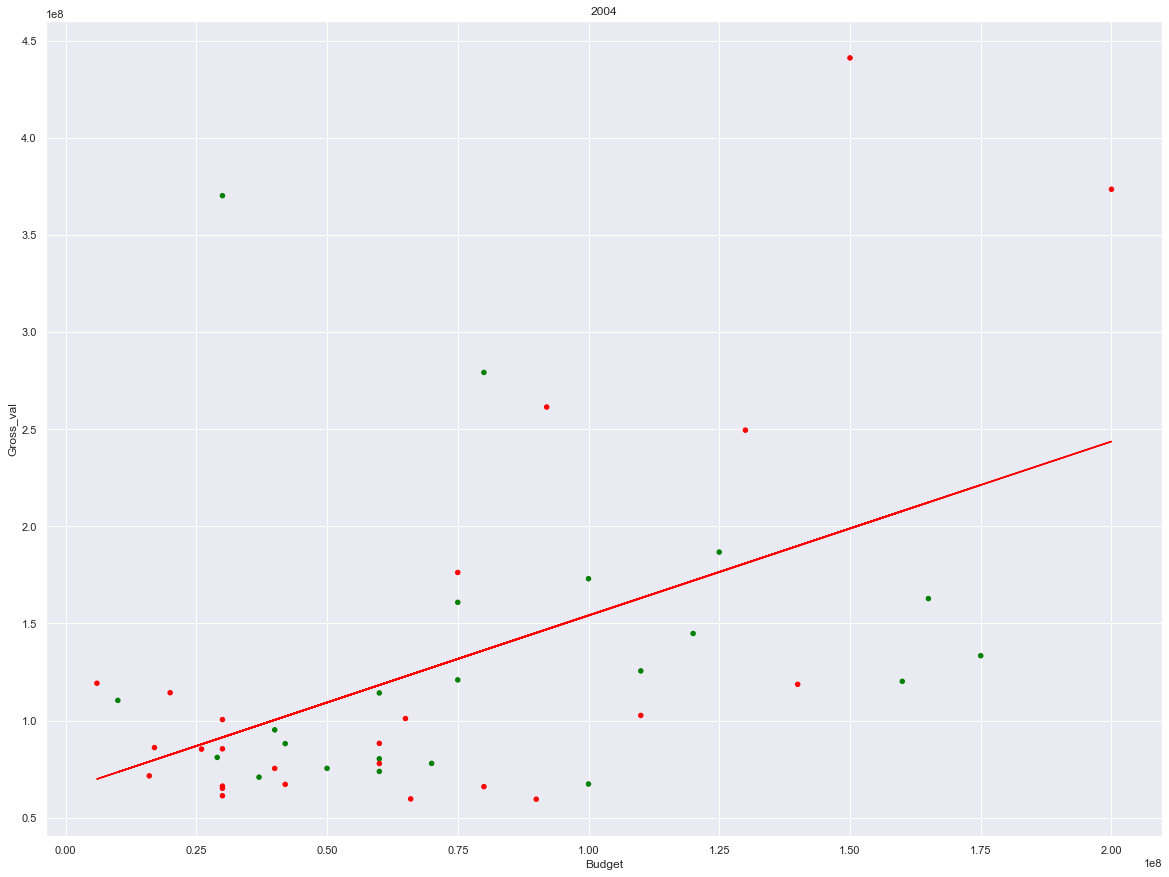

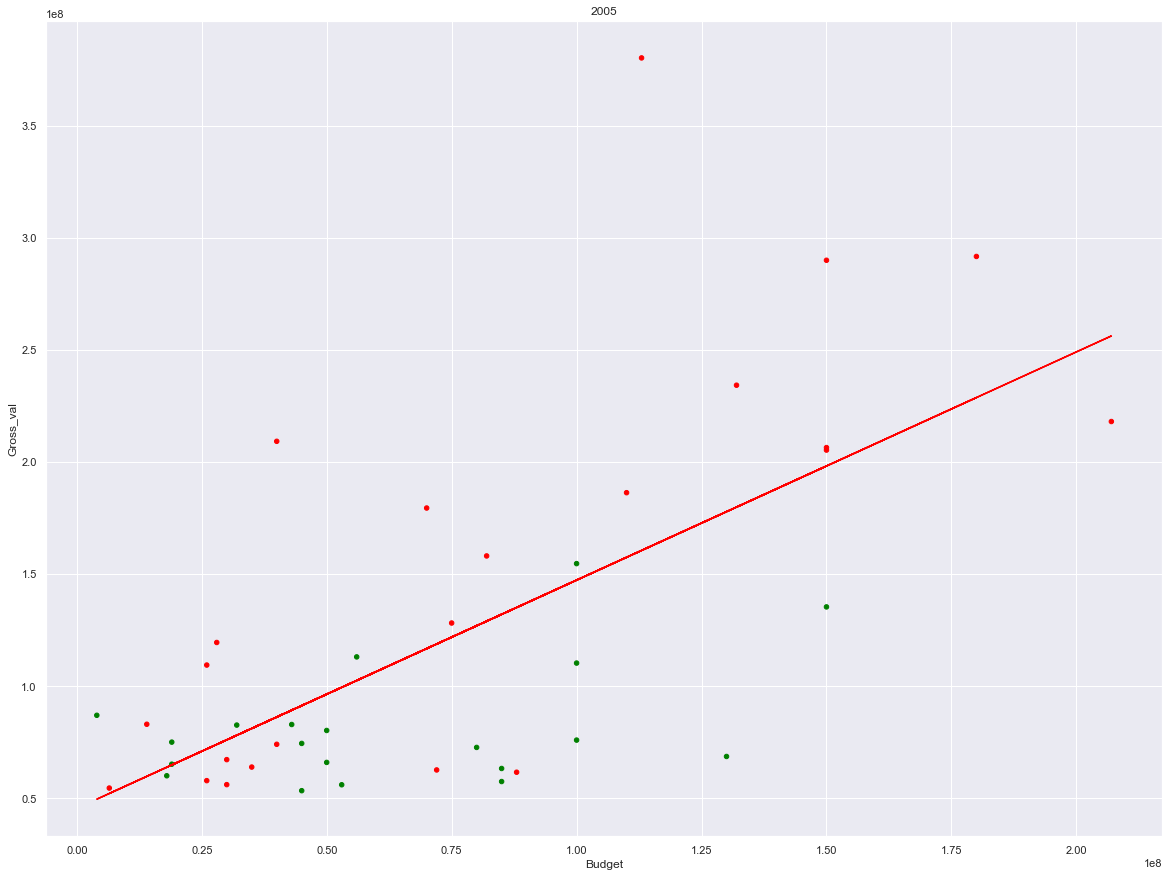

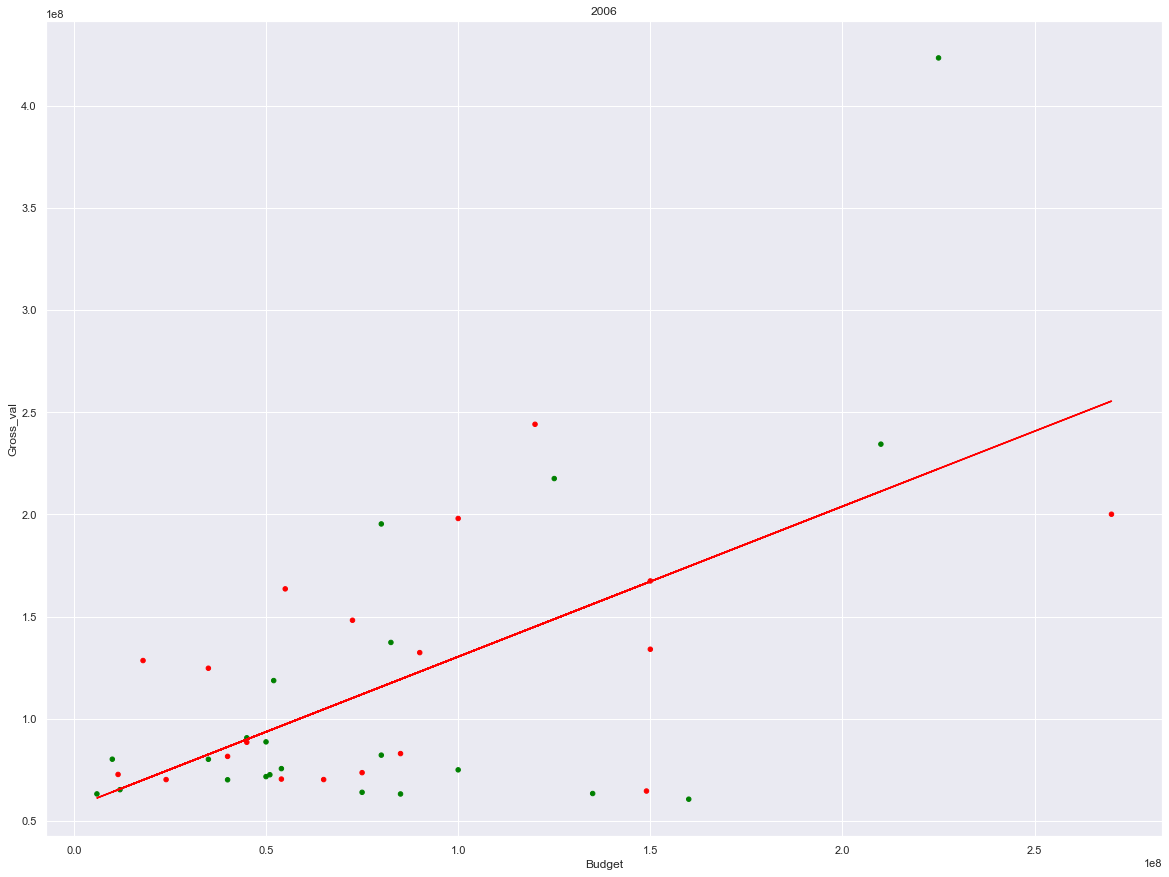

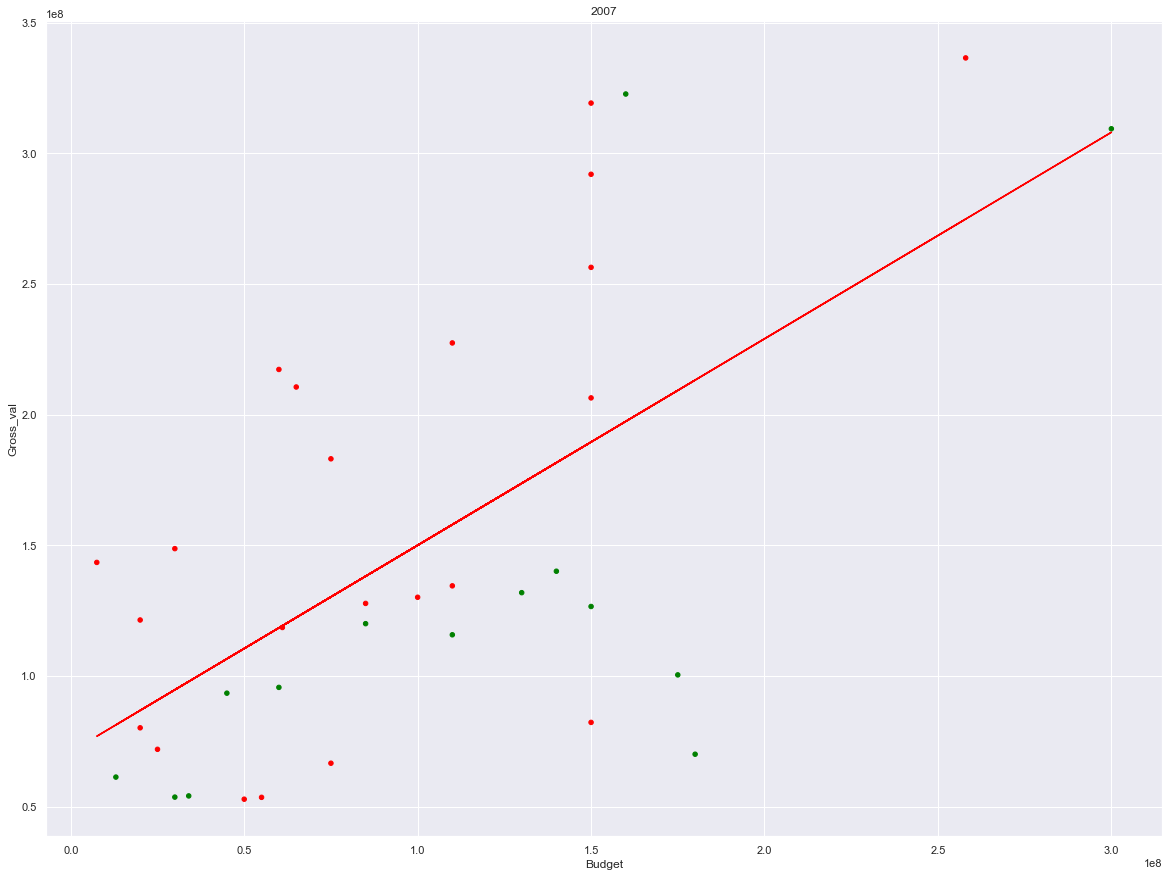

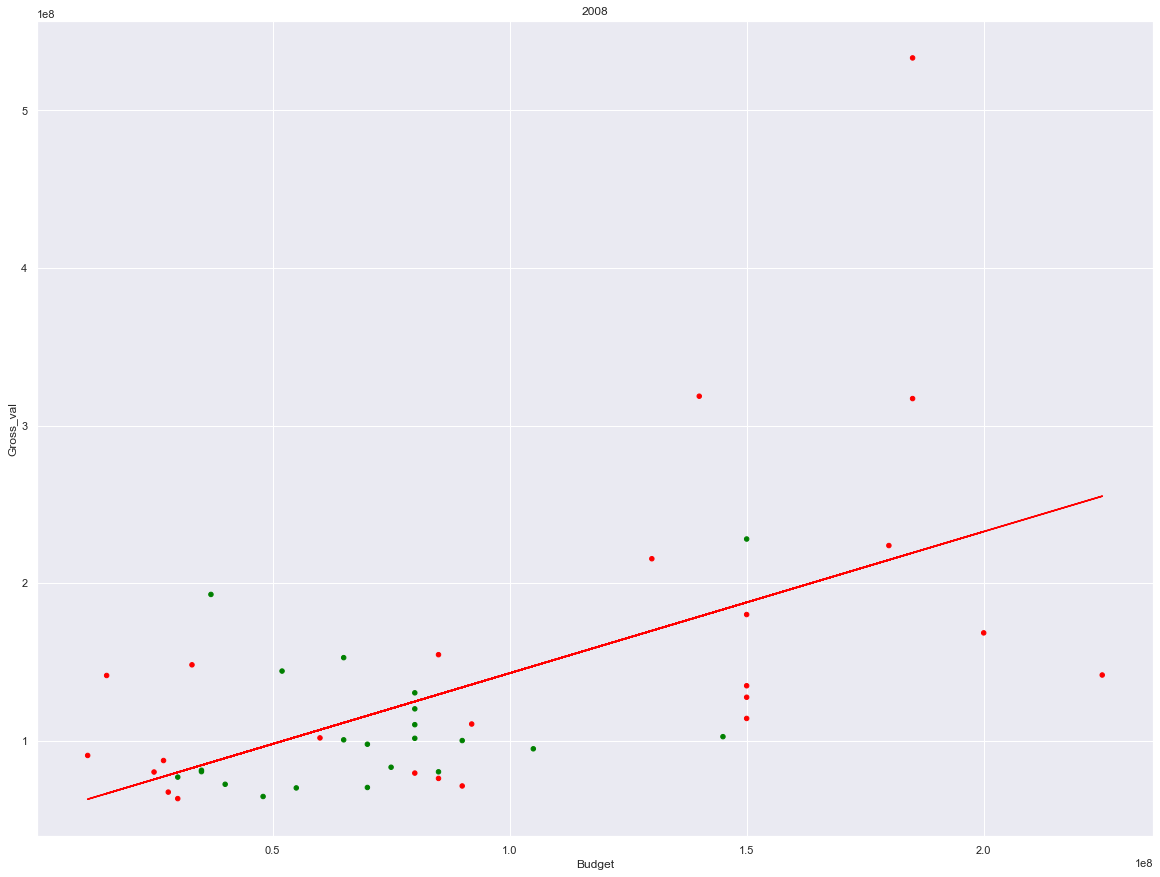

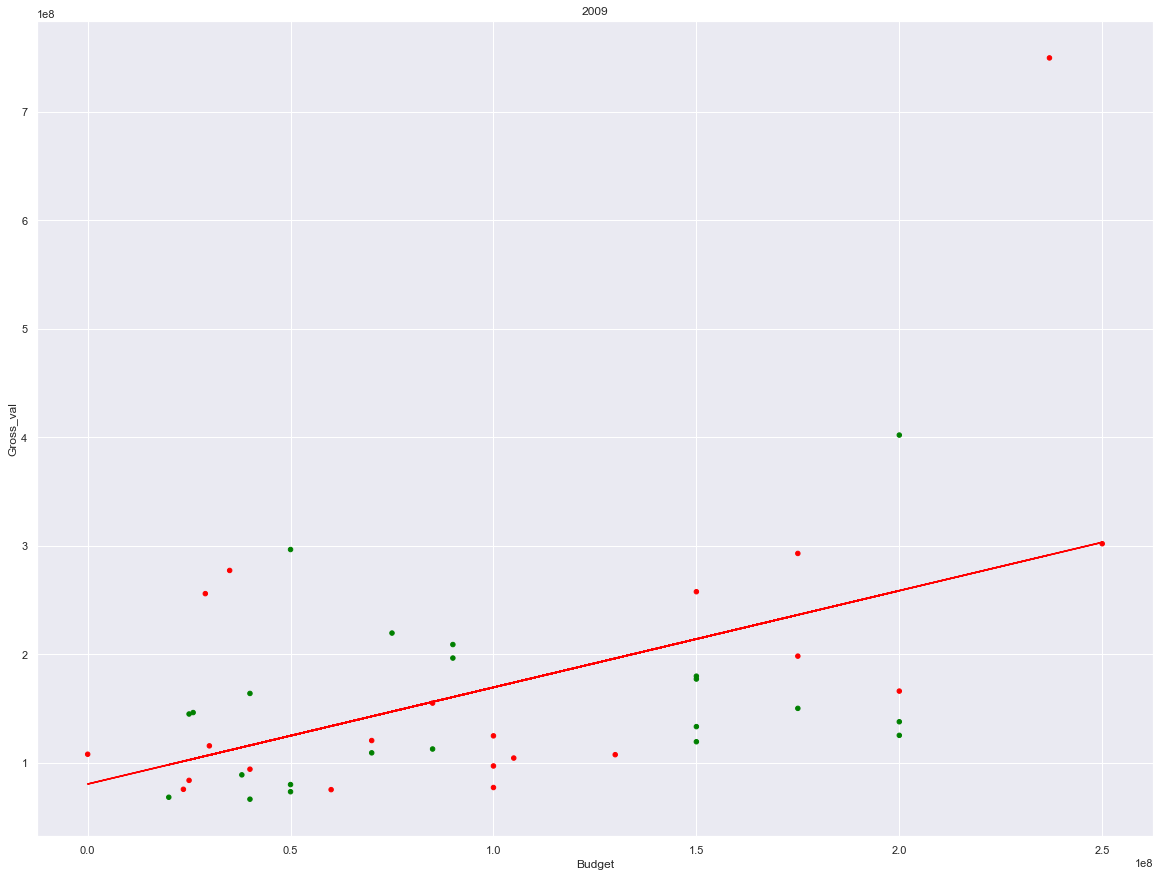

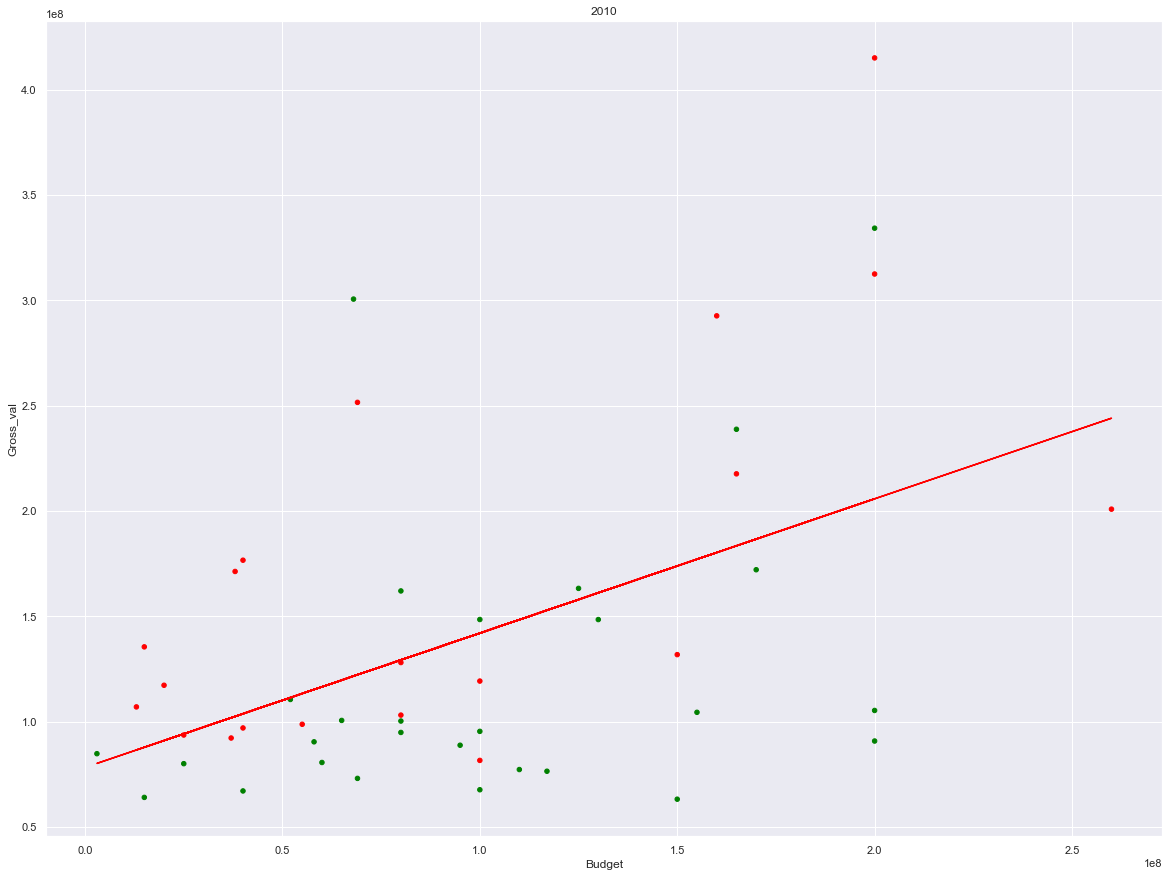

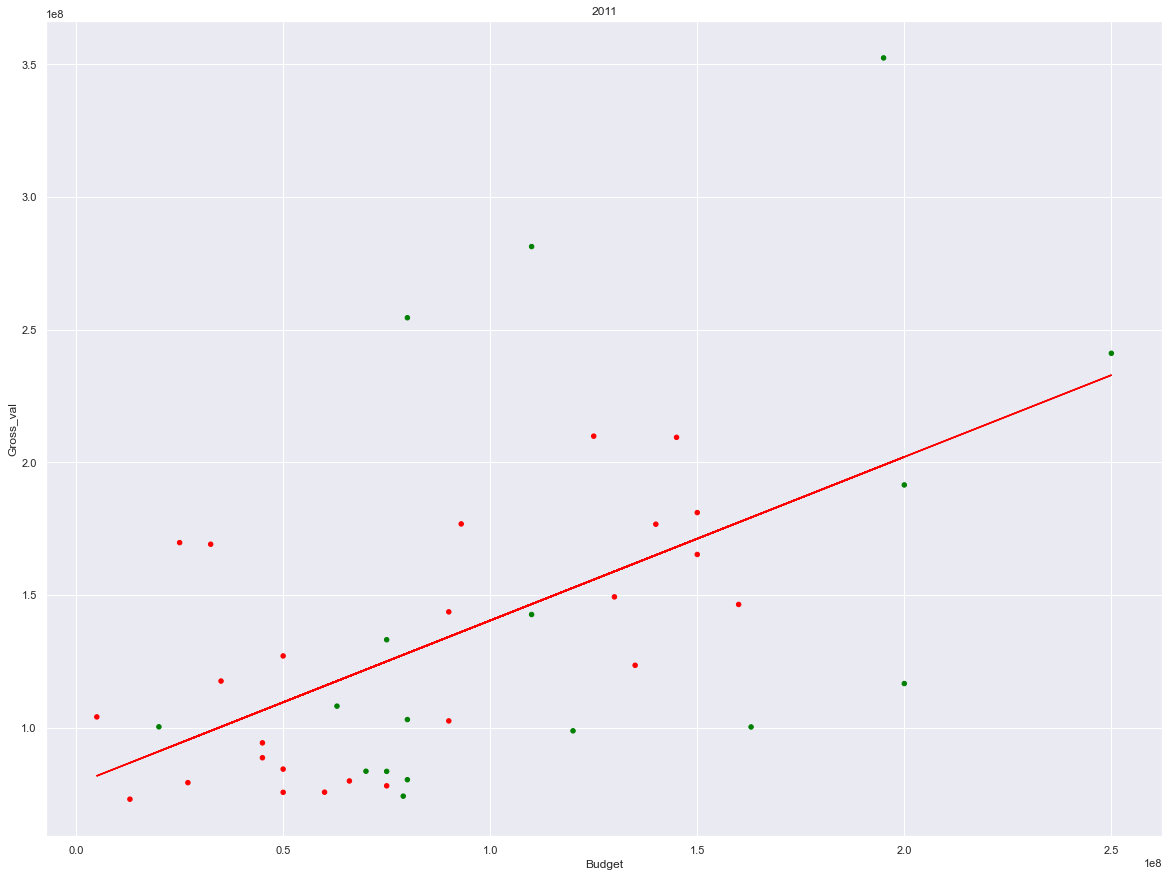

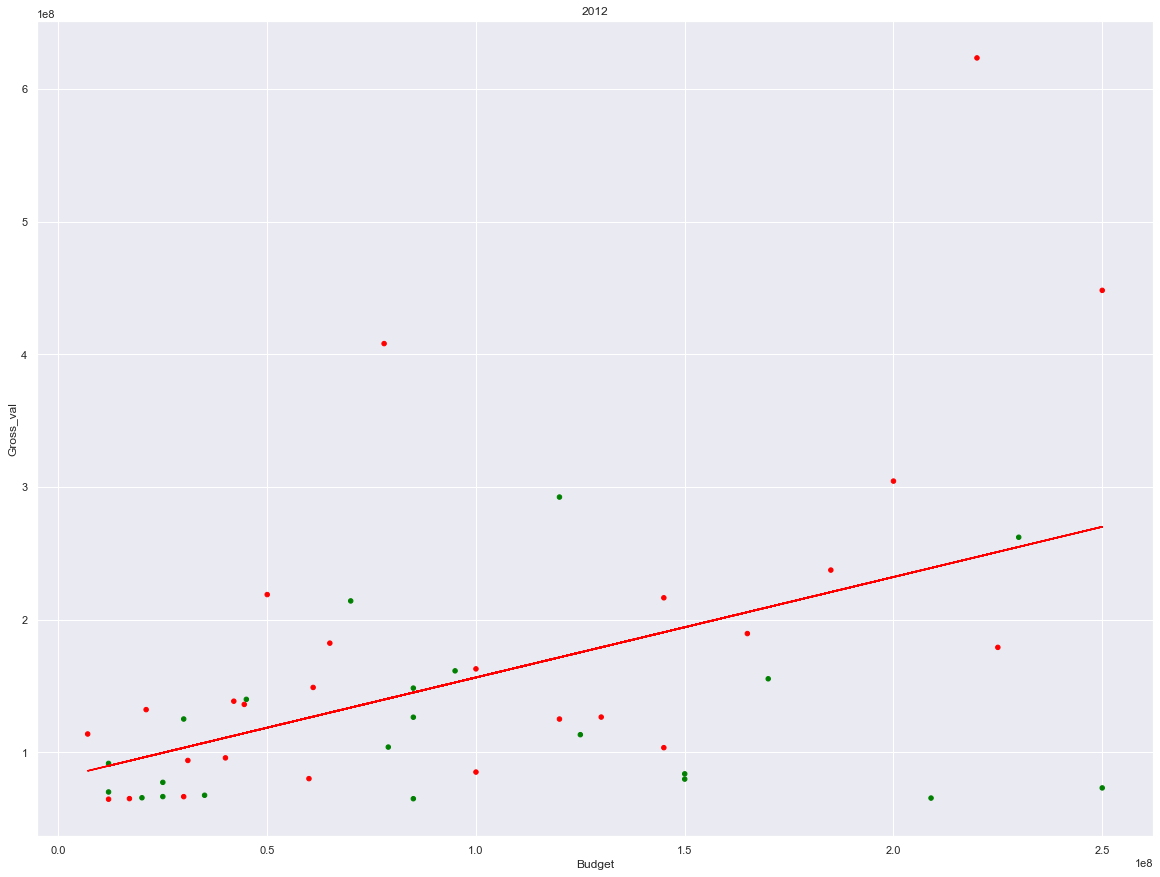

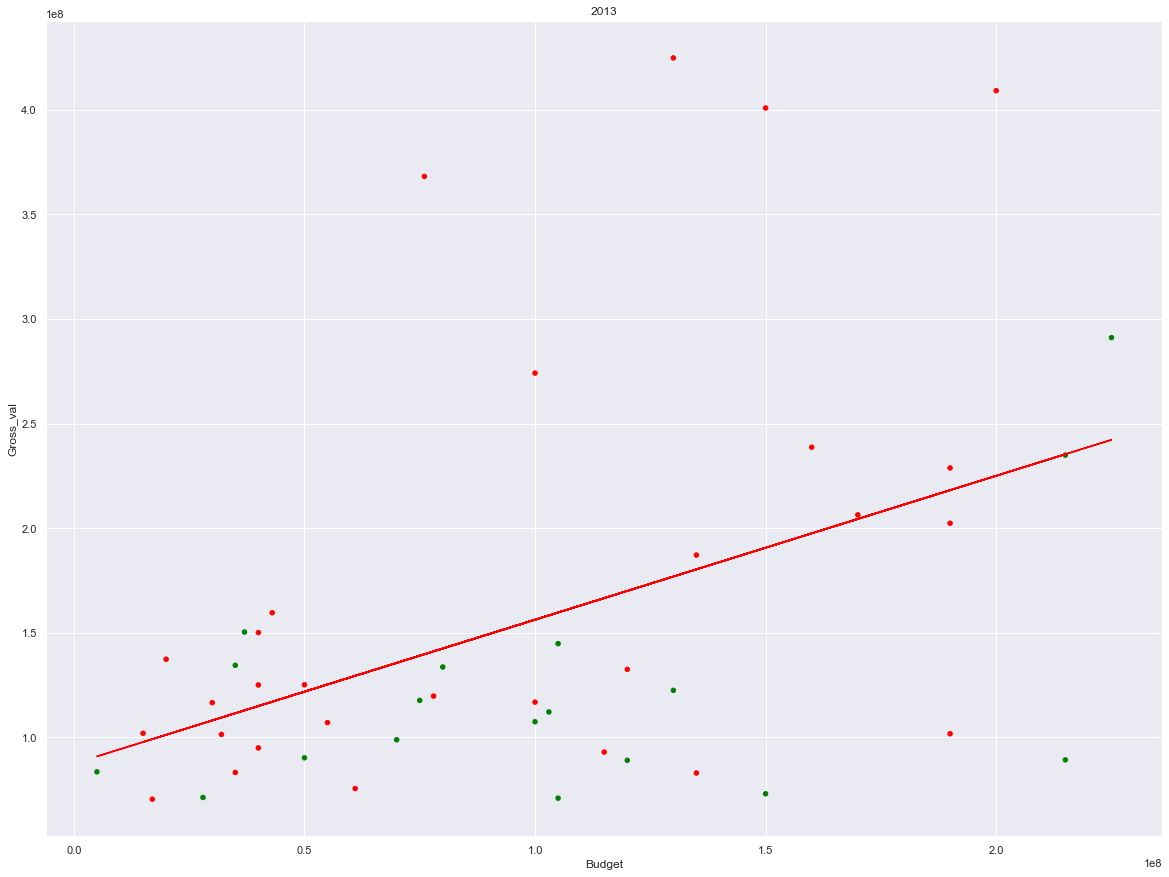

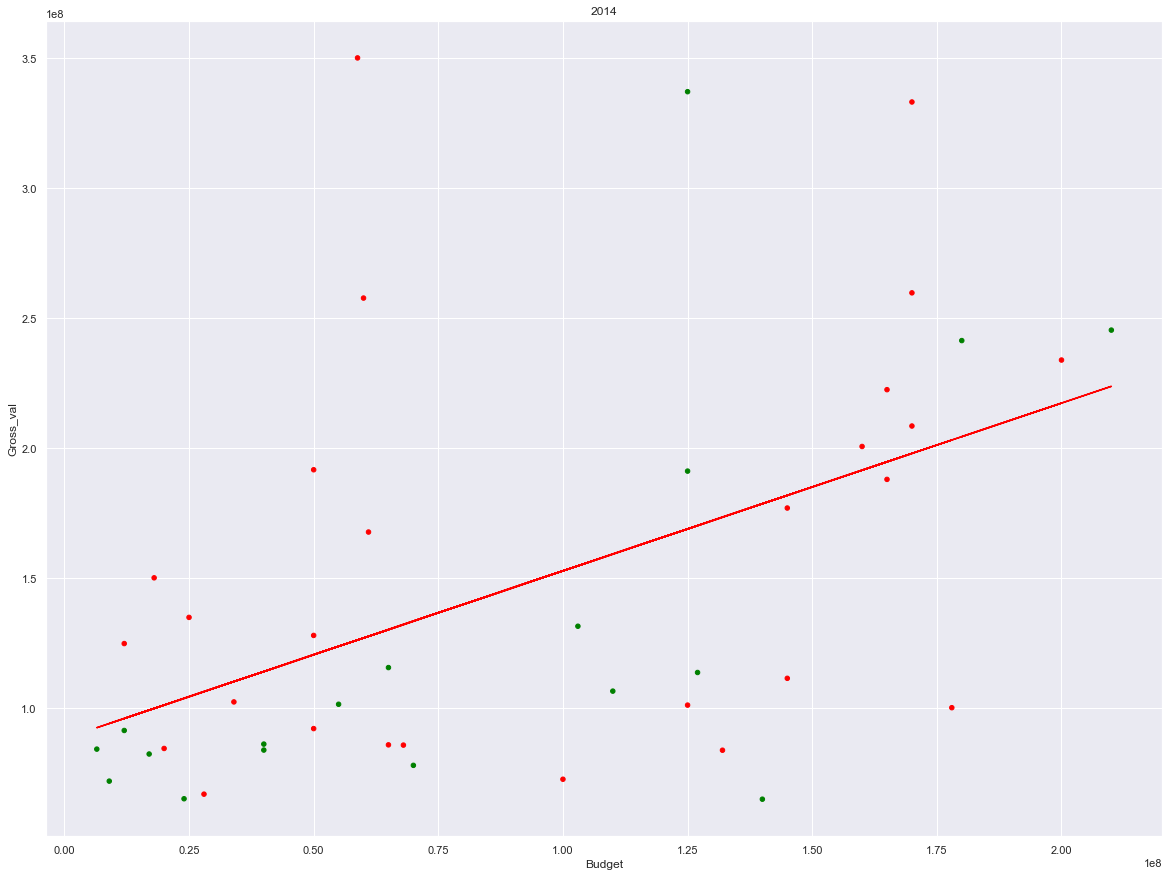

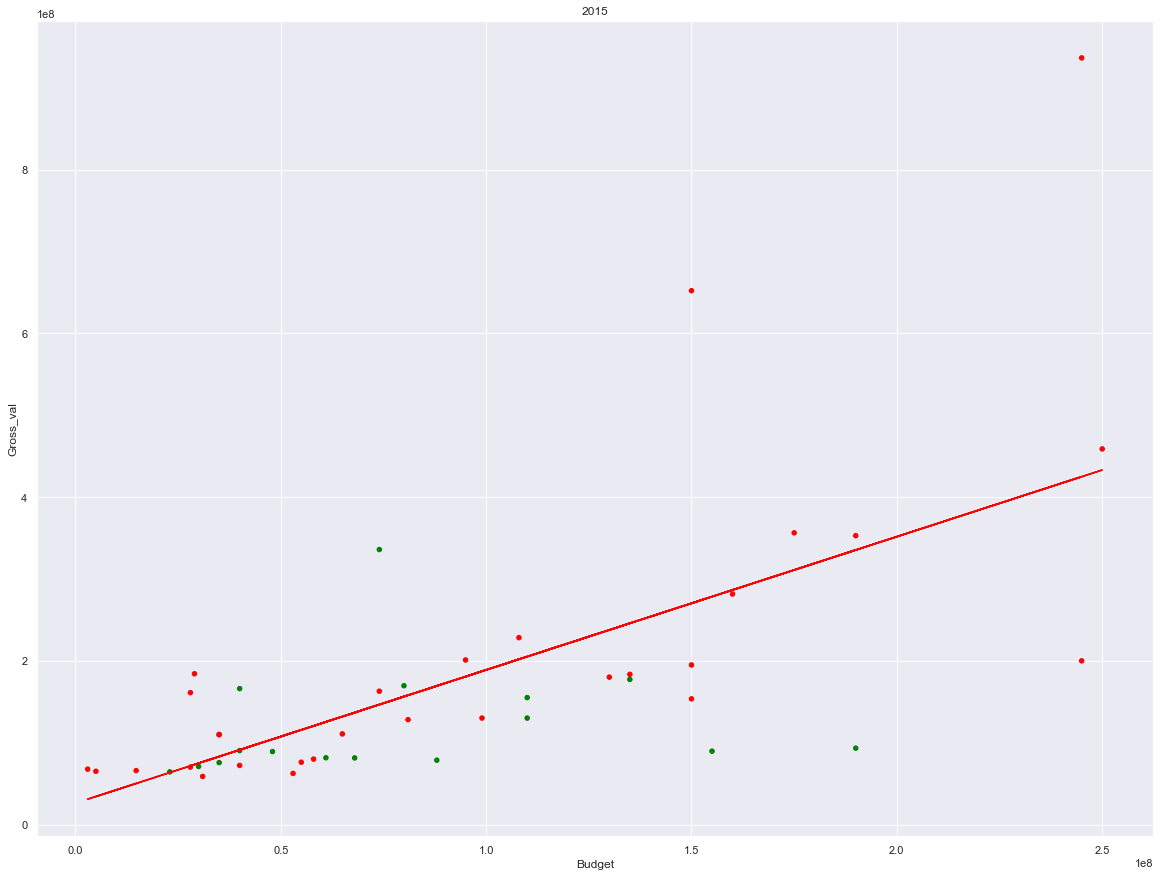

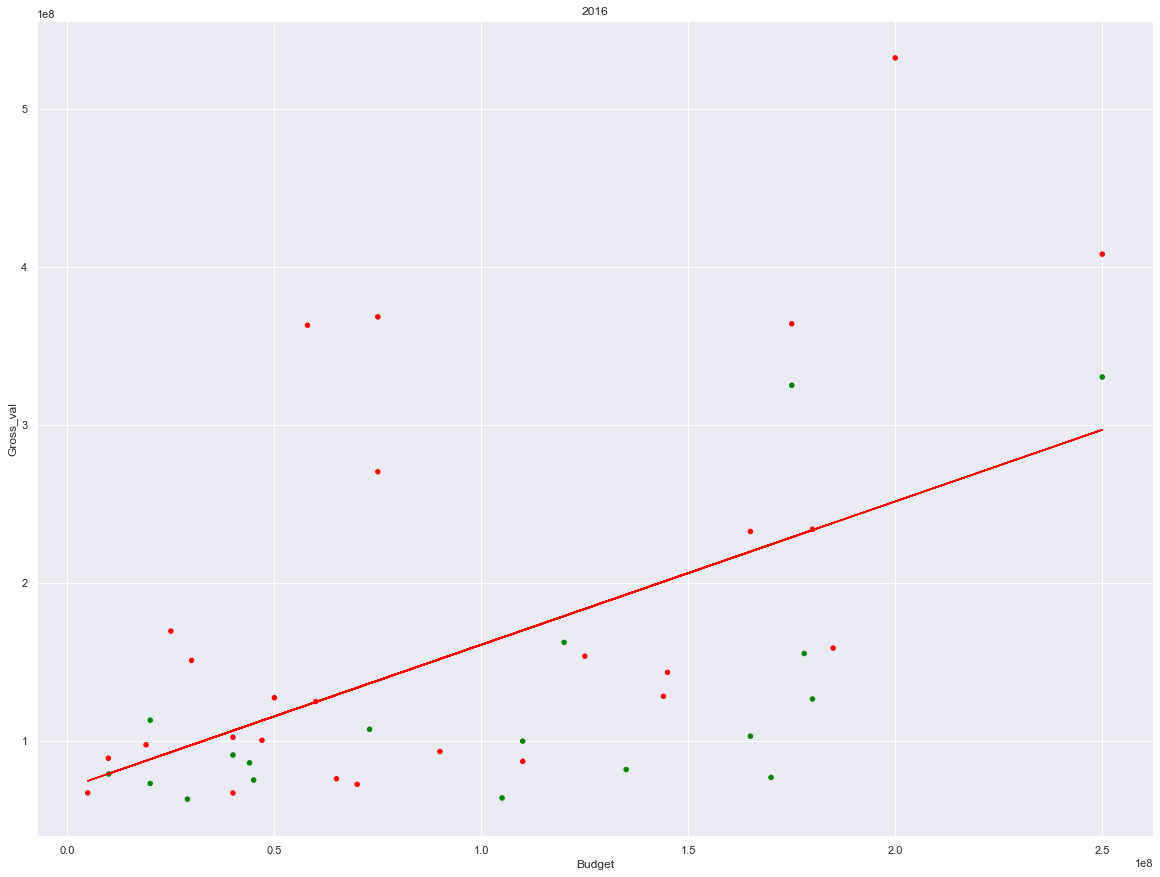

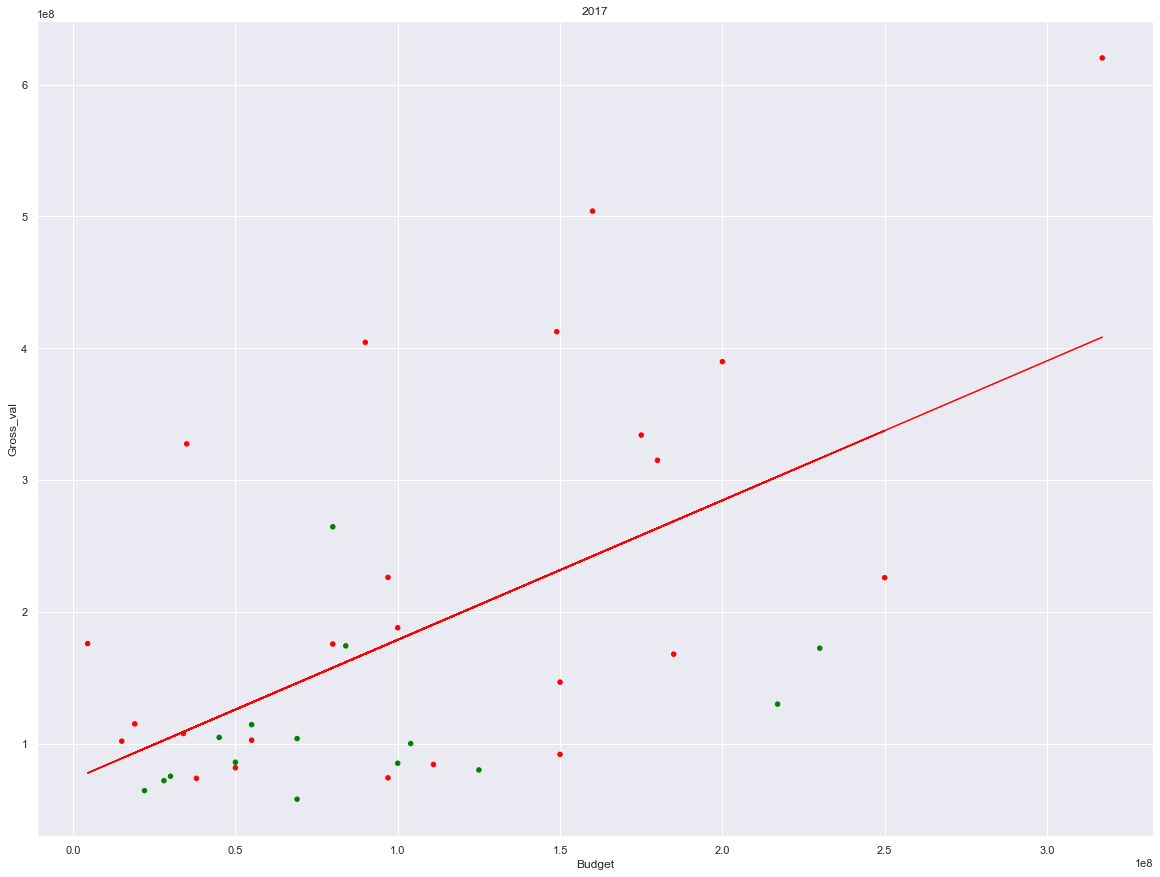

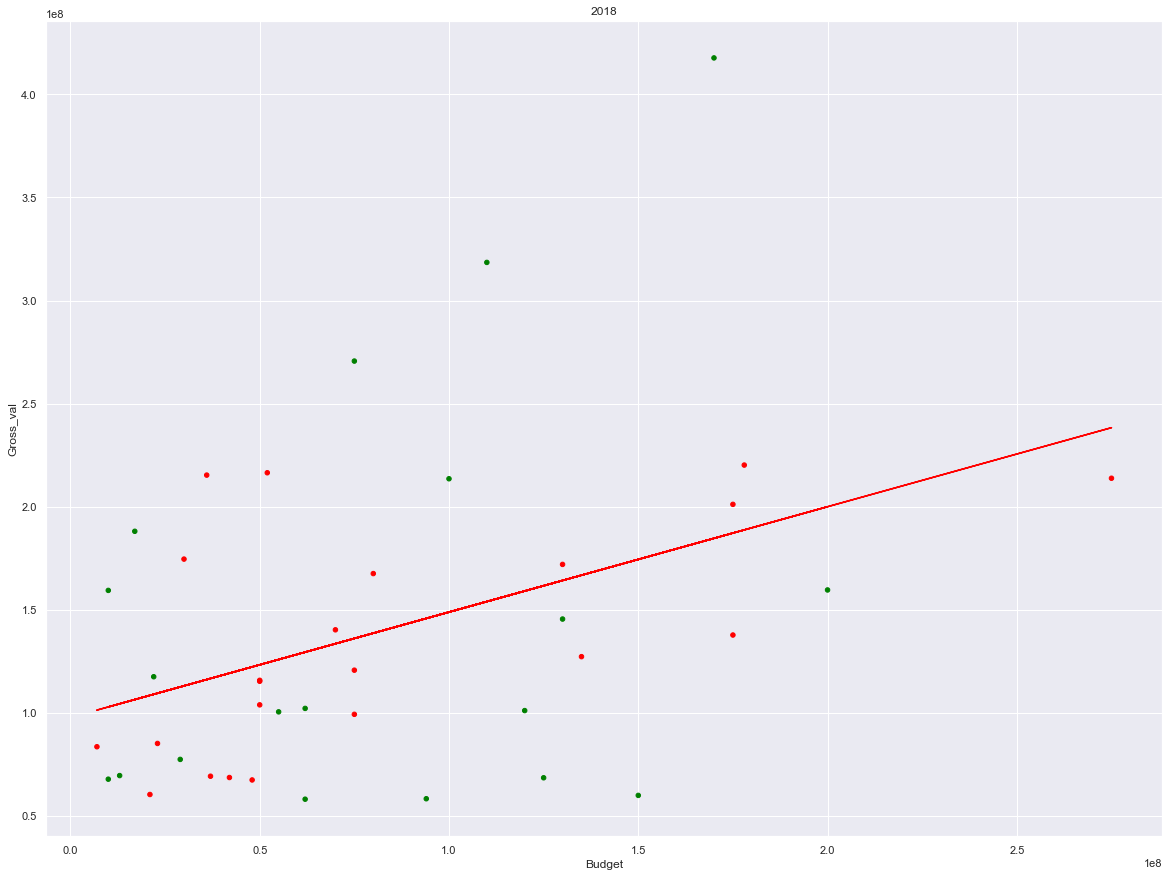

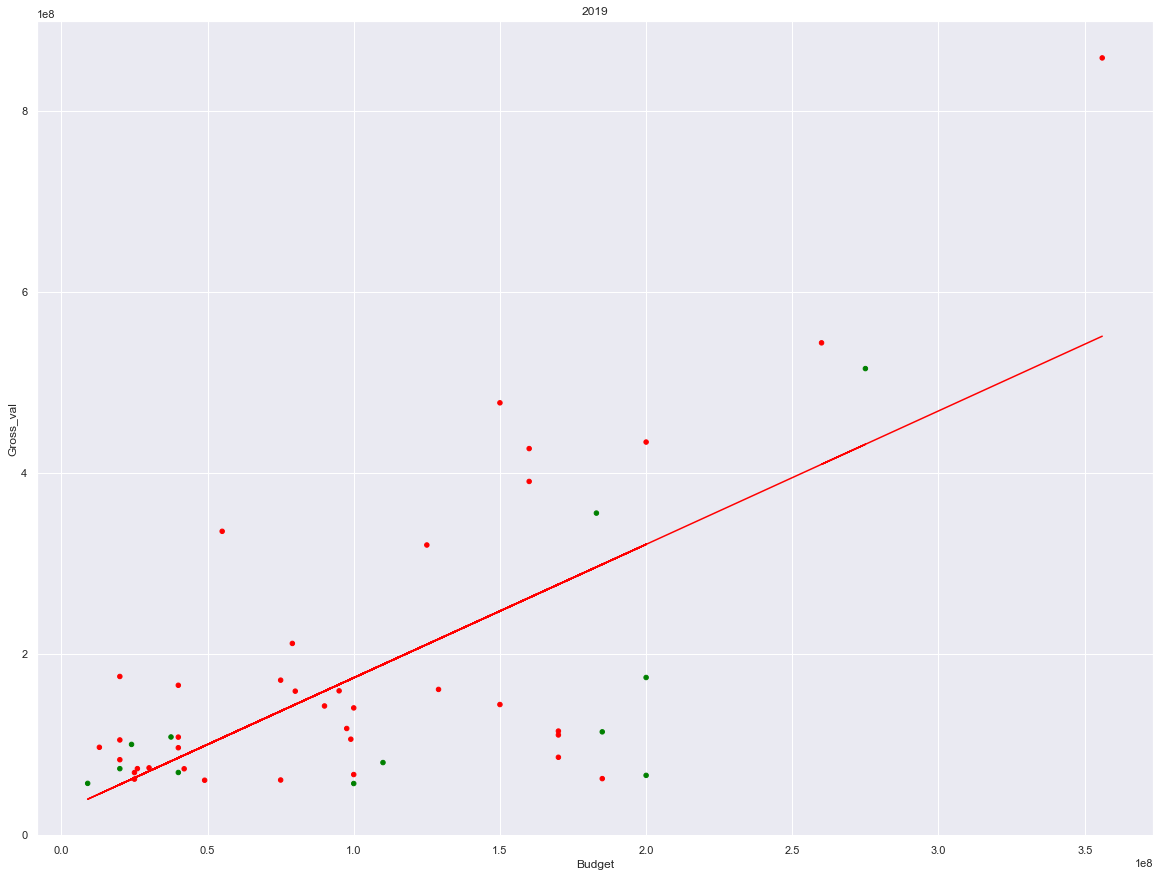

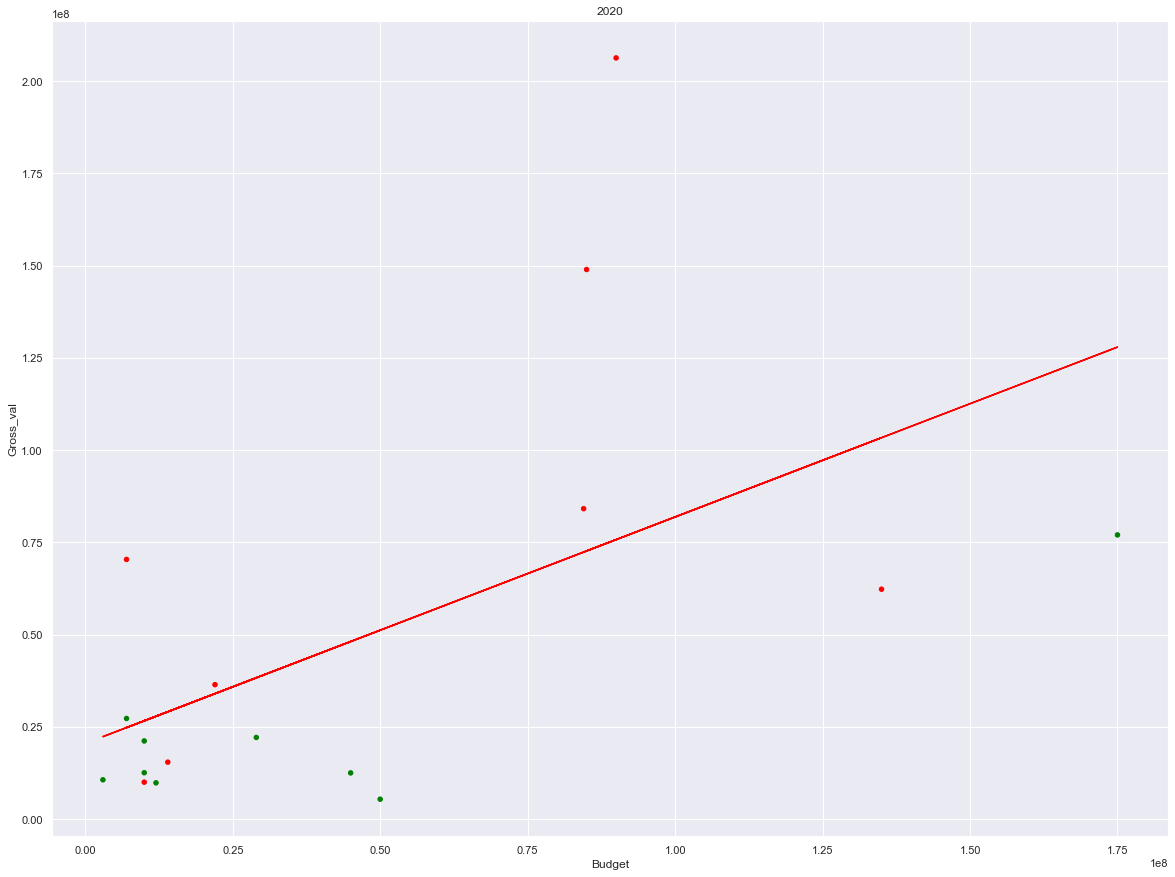

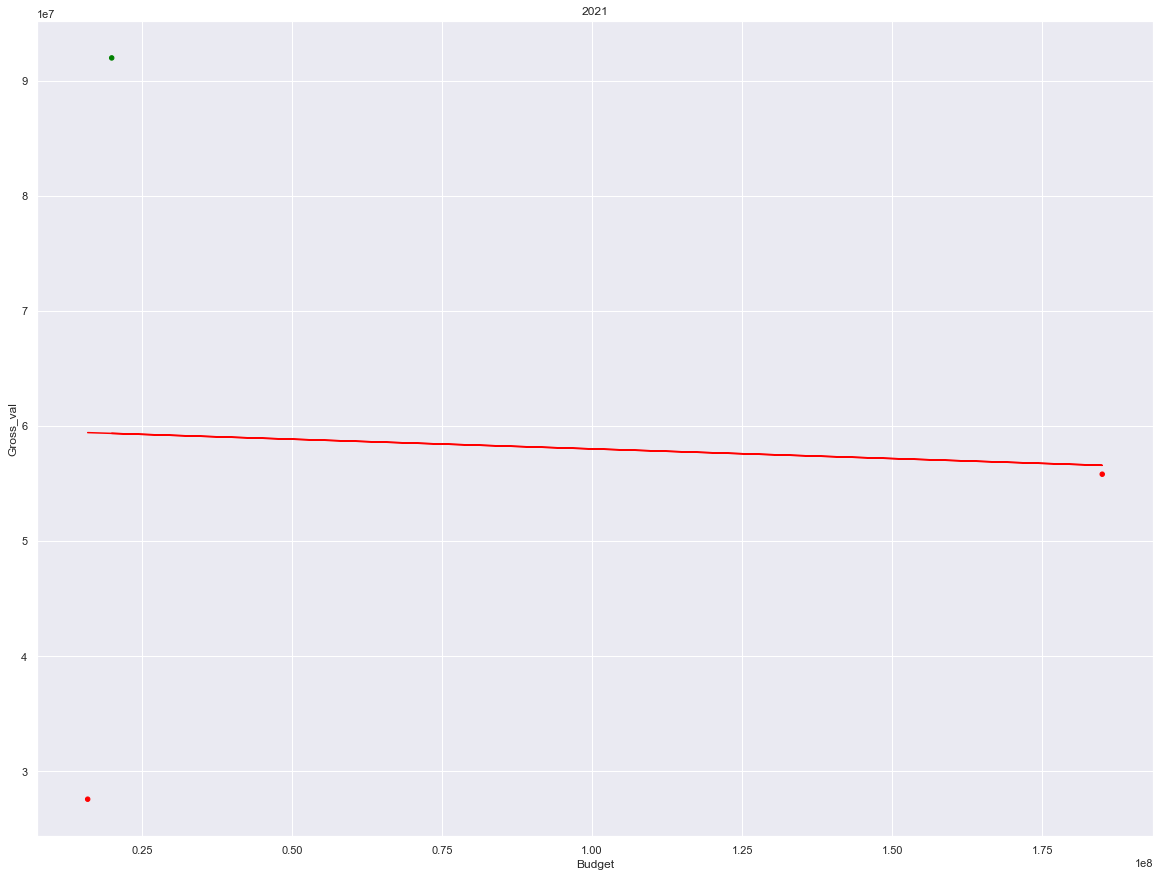

In [290]:
# Taking R_scores of second set of scatterplots, on Budget
r_scores2 = dict()
for yr in years:
    data = movie_gross_table_n.loc[movie_gross_table_n['Year Released'] ==  yr]
    data.plot.scatter(x='Budget', y='Gross_val', title=yr, color=data['fresh_color'])
    X = data.loc[:, 'Budget'].values.reshape(-1, 1)  # iloc[:, 1] is the column of X
    Y = data.loc[:, 'Gross_val'].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    r_scores2[yr] = linear_regressor.score(X, Y)
    #plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')

In [271]:
print("The Coefficient of determinations (R^2) for Highest grossing films from 2000-2021 with respect to their Budget")
for k, v in r_scores2.items():
    print("{}: {}".format(k,v))

The Coefficient of determinations (R^2) for Highest grossing films from 2000-2021 with respect to their Budget
2000: 0.2844946989589766
2001: 0.25388888458760595
2002: 0.26097257154565157
2003: 0.17491282135555675
2004: 0.2408885493692453
2005: 0.4384609454530263
2006: 0.37397246071297774
2007: 0.3937986335725592
2008: 0.33569319500285155
2009: 0.25515773202377556
2010: 0.24357594159926232
2011: 0.31089405979825
2012: 0.24533259810784247
2013: 0.2099851925604339
2014: 0.25621952505250367
2015: 0.4302568762024447
2016: 0.30578829906396476
2017: 0.33268007382288345
2018: 0.16897420121324325
2019: 0.4926167736341708
2020: 0.3132756993493968
2021: 0.0025222924365276844


We see that there is clearly much closer a relationship between the Budget and the eventual Gross, most of the time. This is a seemingly obvious result when you think of a film as an investment by a Production Company. Most of the time, a company would only fund the production of a film if they forsee a great return on investment in their future. Since big budget movies are still getting made, we can presume that studio heads are happy with the revenue their films are generating, which would mean that they continue to fund film projects with big budgets.

As for the reviews, while in some cases, films that have recieved the "Rotten" rating ended with a gross return that was lower than many similarly-budgeted, "Freshly"-reviewed films, It appeared as if this was often also not the case, and "Rotten" films would end with a high domestic return. Our findings (like in the previous set of graphs), are likewise inconclusive. 

## Multiple Regression

In order to make a predictive model, I decided I would try to build a multiple regression model using all 3 of the independent variables that I explored, the Release year, Rotten Tomatoes score, and the Budget. Our null hypothesis we are testing is that there is no relationship between our independent variables and the overall gross of each film. I used statsmodels to test the hypothesis of my model.

In [318]:
X = movie_gross_table_n[['Year Released', 'rt_score','Budget']]
Y = movie_gross_table_n['Gross_val']

linear_regressor = LinearRegression()
lin_reg = linear_regressor.fit(X.astype(float), Y.astype(float))

X = sm.add_constant(X.astype(float))
est = sm.OLS(Y.astype(float), X.astype(float)).fit()
est.summary()

<class 'int'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_val   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     181.9
Date:                Mon, 16 May 2022   Prob (F-statistic):           2.01e-92
Time:                        02:52:04   Log-Likelihood:                -17943.
No. Observations:                 915   AIC:                         3.589e+04
Df Residuals:                     911   BIC:                         3.591e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.12e+09      9e+08     -1.244      0.214   -2.89e+09    6.47e+08
Year Released   5.61e+05   4.48e+05      1.251      0.211   -3.19e+05    1.44e+06
rt_score       9.173e+05   1.04e+05      8.854      0.000    7.14e+05    1.12e+06
Budget            0.9042      0.044     20.372      0.000       0.817       0.991
==============================================================================
Omnibus:                      395.841   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2813.759
Skew:                           1.822   Prob(JB):                         0.00
Kurtosis:                      10.780   Cond. No.                     3.58e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, due to a high P-value (over .05 which is standard), our model does not believe the 'Year Released' attribute is statistically significant. On the other hand, I am happy to confirm the significance of the Rotten Tomato score and Budget, which have a P-value of 0, meaning they are statistically significant. As shown in my previous explorations, I believed that these two attributes were correlated to the Gross, even if it wasn't too clear by our model. Our coefficient of determination is at 37.5%. 

## Conclusion and Future Steps

In this tutorial, we took a look at the domestic gross of films in the 21st century and noticed some significant trends and behaviors that stem from a variety of issues that are currently hindering the movie industry. In particular, we noticed how less and less people have been buying tickets and going to the movie theatres. Despite this trend, recently, a small number of films are breaking records, and earning far more revenue than the years before, however the average number of moviegoers are declining, which means that when most people decide to go to the movies, it is only for a select few, the big-budget blockbusters. A lot of times, these films aren't even well-recieved, but because there is so much money thrown at these franchises, remakes, and adapted pictures, a grand majority of them lead to success, taking away the spotlight from other smaller, independent, and creatively ambitous films. These problems have only been exacerbated by the COVID-19 pandemic.

In order to improve this tutorial, We should look at the genre of each of these films. Unfortunately, since genre is subjective, and most films belong to more than one genre, we have to be careful when analyzing that data. We can then see the impact of genre on domestic revenue, and whether there are certain genre's of film where the critic response is more significant. Regarding those critic reviews, it would also be smart to compare the critic review scores to those of the general audience, since those can vary wildly. Since it is that group that contributes mostly to the domestic gross of the picture, what their positive/negative response is significant to knowing how many people actually decide a ticket. Since Rotten tomatoes also uses a slightly unorthodox aggregate review score, it might be effective to try scraping a more tradition rating system, as Rotten Tomatoes can really only tell us if a movie is generally well-regarded or not. While I wasn't able to pinpoint the effects of alternative media on the film industry (aka streaming), it is thing to explore, the only issue is that data-keeping for streaming, since it is a relatively new medium, is sparse, unorganized, and often missing. Also, as we move further and further away from the darkest times of the pandemic, we can redo this tutorial with more of an emphasis on how these trends have changed.

Cinema has played a crucial role in many of our lives. They are ways to tell stories, to make us laugh, and to make us cry. They are meant to entertain but they are also there to challenge your ideas. That's why the multiplex has been such a staple part of our society, everybody loves going to the movies so that's why we can't let it die!



Made by: [Daniel Lopez](https://www.linkedin.com/in/danials2001)